In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import pickle
import networkx as nx
from scipy.stats.mstats import gmean
from scipy.stats import spearmanr, ks_2samp
from scipy.signal import find_peaks, peak_prominences
from load_files_pop import (
    Ref,
    Z_20,
    Ref_pop20,
    Z_200,
    Ref_pop200,
    Z_2000,
    Ref_pop2000
)
from Reference_pop import simulate_reference_time_series
from plot_search_results import (
    plot_pareto_front3D,
    plot_pulse_ensemble_time_series,
    plot_ref_ensemble_time_series
)
from amplifier_problem import Amplifier
from signal_conditioner_problem import SignalConditioner

orange_ = [i/255 for i in [230, 159, 0]]
sky_blue = [i/255 for i in [86, 180, 233]]
pink_ = [i/255 for i in [204, 121, 167]]
bluish_green = [i/255 for i in [0, 158, 115]]
vermillion = [i/255 for i in [213, 94, 0]]
yellow_ = [i/255 for i in [240, 228, 66]]
blue_ = [i/255 for i in [0, 114, 178]]

colors = [orange_, sky_blue, pink_, bluish_green, vermillion, yellow_, blue_]

Z_200_df = pd.DataFrame(data = Z_200, columns = ["plasmid_" + str(i) for i in range(9)])
Z_200_df = Z_200_df.drop(labels=["plasmid_" + str(i) for i in range(5,9)], axis=1)
Z_200_df["average"] = np.mean(Z_200_df, axis=1)

# Pulse test case

### Labeling topologies on pareto front- single cell model

In [37]:
def sort_in_dict(in_dict):
    sorted_in_dict = {}
    for key, val in in_dict.items():
    # print(key, val)
        val_sorted = {}
        for subkey, subval in val.items():
            subval.sort()
        #     print(subkey, subval)
            val_sorted.update({subkey: subval})
        sorted_in_dict.update({key: val_sorted})
    return sorted_in_dict


def generalize_in_dict(in_dict):
    in_dict_general = {}
    # format of keys: "part|regulator1|regulator2|..."
    for key, value in in_dict.items():
        i = 0
        key_reg = key[0]
        if len(value["P"]) > 0:
            key_reg += "P"
        if len(value["Z"]) > 0:
            key_regZ = ""
            for Zreg in value["Z"]:
                if Zreg == key:
                    key_regZ += "A"
                else:
                    key_regZ += "Z"
            key_regZ = "".join(sorted(key_regZ))
            key_reg += key_regZ
        if len(value["I"]) > 0:
            key_regI = ""
            for Ireg in value["I"]:
                if Ireg == key:
                    key_regI += "A"
                else:
                    key_regI += "I"
            key_regI = "".join(sorted(key_regI))
            key_reg += key_regI
        in_dict_general.update({key_reg: value})
    
    return in_dict_general

In [ ]:
path_pulse = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_5/2024-10-11_results_analysis/"
fname = "selected_results_full_pareto.pkl"
pulse_pareto = pd.read_pickle(path_pulse+fname)

objs0 = []
in_dict0 = {'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'I13': {'P': [], 'Z': ['Z6'], 'I': []}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': []}}

sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = []
in_dict1 = {'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'I13': {'P': ['P1'], 'Z': ['Z6'], 'I': []}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': []}}

sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'I13': {'P': [], 'Z': ['Z6'], 'I': []}, 'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': ['I13']}}

sorted_in_dict2 = sort_in_dict(in_dict2)




in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
print(in_dict2_general.keys())

# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general]
keys_list = [d.keys() for d in dict_list_general]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_t_pulse": [],
    "opt_0_prom_rel": [],
    "opt_0_doses": [],

    "opt_1_topology": [],
    "opt_1_t_pulse": [],
    "opt_1_prom_rel": [],
    "opt_1_doses": [],
    
    "opt_2_topology": [],
    "opt_2_t_pulse": [],
    "opt_2_prom_rel": [],
    "opt_2_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_t_pulse": [],
    "opt_0_var_prom_rel": [],
    "opt_0_var_doses": [],

    "opt_1_var_topology": [],
    "opt_1_var_t_pulse": [],
    "opt_1_var_prom_rel": [],
    "opt_1_var_doses": [],


    "opt_2_var_topology": [],
    "opt_2_var_t_pulse": [],
    "opt_2_var_prom_rel": [],
    "opt_2_var_doses": [],
}

for index, row in pulse_pareto.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Parts order"]
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_t_pulse"].append(row["t_pulse"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_prom_rel"].append(row["prominence_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        variant_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        opt_variants["opt_"+str(variant_idx)+"_var_topology"].append(row["Topology"])
        opt_variants["opt_"+str(variant_idx)+"_var_t_pulse"].append(row["t_pulse"])
        opt_variants["opt_"+str(variant_idx)+"_var_prom_rel"].append(row["prominence_rel"])
        opt_variants["opt_"+str(variant_idx)+"_var_doses"].append(row["Topology"].dose)


    # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
display(opt_circuits_df)
opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
opt_circuits_df.to_csv(path_pulse+"labeled_pareto_circuits.csv")
opt_variants_df.to_csv(path_pulse+"labeled_pareto_circuit_variants.csv")

### Labeling topologies on pareto front- pop20 frac_pulse

In [ ]:
path_pulse = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Pulse_seed_pop_DsRED_inhibitor/frac_pulse/Pulse_pop_DsRED_inhibitor_3obj_frac_pulse_pop200_ngen100/2024-10-13_Pulse_pop_DsRED_inhibitor_3obj_frac_pulse_pop200_ngen100/2024-10-13_results_analysis/"
fname0 = "0_025/selected_results_low_frac_p.pkl"
fname1 = "025_03/selected_results_mid_pulse.pkl"
fname2 = "03_04/selected_results_mid_pulse.pkl"
fname3 = "04_05/selected_results_mid_pulse.pkl"
fname4 = "05_06/selected_results_mid_pulse.pkl"
fname5 = "06_07/selected_results_mid_pulse.pkl"
fname6 = "07_08/selected_results_mid_pulse.pkl"

pulse_pareto0 = pd.read_pickle(path_pulse+fname0)
pulse_pareto1 = pd.read_pickle(path_pulse+fname1)
pulse_pareto2 = pd.read_pickle(path_pulse+fname2)
pulse_pareto3 = pd.read_pickle(path_pulse+fname3)
pulse_pareto4 = pd.read_pickle(path_pulse+fname4)
pulse_pareto5 = pd.read_pickle(path_pulse+fname5)
pulse_pareto6 = pd.read_pickle(path_pulse+fname6)

df_full_pareto = pd.concat([pulse_pareto0, pulse_pareto1, pulse_pareto2, pulse_pareto3, pulse_pareto4, pulse_pareto5, pulse_pareto6], axis=0)
# display(df_full_pareto)

objs0 = []
in_dict0 = {'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'I13': {'P': [], 'Z': ['Z6'], 'I': []}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': []}}

sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = []
in_dict1 = {'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'I13': {'P': ['P1'], 'Z': ['Z6'], 'I': []}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': []}}

sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'I13': {'P': [], 'Z': ['Z6'], 'I': []}, 'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': ['I13']}}

sorted_in_dict2 = sort_in_dict(in_dict2)

objs3 = []
in_dict3 = {'Z6': {'P': ['P1'], 'Z': ['Z6'], 'I': ['I13']}, 'I13': {'P': ['P1'], 'Z': ['Z6'], 'I': []}, 'Rep': {'P': [], 'Z': ['Z6'], 'I': ['I13']}}

sorted_in_dict3 = sort_in_dict(in_dict2)


in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
# print(in_dict2_general.keys())
in_dict3_general = generalize_in_dict(in_dict3)
# print(in_dict3_general.keys())

# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2, sorted_in_dict3]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general, in_dict3_general]
keys_list = [d.keys() for d in dict_list_general]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_frac_pulse": [],
    "opt_0_t_pulse": [],
    "opt_0_prom_rel": [],
    "opt_0_doses": [],

    "opt_1_topology": [],
    "opt_1_frac_pulse": [],
    "opt_1_t_pulse": [],
    "opt_1_prom_rel": [],
    "opt_1_doses": [],
    
    "opt_2_topology": [],
    "opt_2_frac_pulse": [],
    "opt_2_t_pulse": [],
    "opt_2_prom_rel": [],
    "opt_2_doses": [],

    "opt_3_topology": [],
    "opt_3_frac_pulse": [],
    "opt_3_t_pulse": [],
    "opt_3_prom_rel": [],
    "opt_3_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_frac_pulse": [],
    "opt_0_var_t_pulse": [],
    "opt_0_var_prom_rel": [],
    "opt_0_var_doses": [],

    "opt_1_var_topology": [],
    "opt_1_var_frac_pulse": [],
    "opt_1_var_t_pulse": [],
    "opt_1_var_prom_rel": [],
    "opt_1_var_doses": [],


    "opt_2_var_topology": [],
    "opt_2_var_frac_pulse": [],
    "opt_2_var_t_pulse": [],
    "opt_2_var_prom_rel": [],
    "opt_2_var_doses": [],

    "opt_3_var_topology": [],
    "opt_3_var_frac_pulse": [],
    "opt_3_var_t_pulse": [],
    "opt_3_var_prom_rel": [],
    "opt_3_var_doses": [],
}

for index, row in df_full_pareto.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Parts order"]
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_frac_pulse"].append(row["frac_pulse"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_t_pulse"].append(row["t_pulse"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_prom_rel"].append(row["prominence_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        variant_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        opt_variants["opt_"+str(variant_idx)+"_var_topology"].append(row["Topology"])
        opt_variants["opt_"+str(variant_idx)+"_var_frac_pulse"].append(row["frac_pulse"])
        opt_variants["opt_"+str(variant_idx)+"_var_t_pulse"].append(row["t_pulse"])
        opt_variants["opt_"+str(variant_idx)+"_var_prom_rel"].append(row["prominence_rel"])
        opt_variants["opt_"+str(variant_idx)+"_var_doses"].append(row["Topology"].dose)


#     # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
display(opt_circuits_df)
display(opt_variants_df)
# opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
opt_circuits_df.to_csv(path_pulse+"labeled_CI_circuits.csv")
opt_variants_df.to_csv(path_pulse+"labeled_CI_circuit_variants.csv")

# print(opt_circuits["opt_3_topology"])

### Spline fitting

In [70]:
def fit_spline_condition(all_cell_list):

    time_points = [14, 18, 22, 26, 38, 42, 46]
    pulse_rel_all_cells = []
    for i in range(len(all_cell_list)):
        pulse_rep_rel = all_cell_list[i]
        rep_rel_t_exp = [pulse_rep_rel[t] for t in time_points]
        pulse_rel_all_cells.append(rep_rel_t_exp)
    pulse_rel_t_exp_df = pd.DataFrame(pulse_rel_all_cells, columns = time_points)
    pulse_rel_t_exp_df_T = pulse_rel_t_exp_df.transpose().copy()
    pulse_rel_t_exp_df_T["Time (h)"] = pulse_rel_t_exp_df_T.index
    pulse_rel_t_exp_df_T_plot = pd.melt(frame=pulse_rel_t_exp_df_T,
                                      id_vars="Time (h)",
                                      var_name="column_name",
                                      value_name="Rep_rel")
    pulse_rel_t_exp_df_T_plot_sorted = pulse_rel_t_exp_df_T_plot.sort_values("Time (h)")
    spline_condition = np.polyfit(pulse_rel_t_exp_df_T_plot_sorted["Time (h)"].tolist(), pulse_rel_t_exp_df_T_plot_sorted["Rep_rel"].tolist(), deg=3.5)
    poly_spline = np.poly1d(spline_condition)
    spline_derivative = poly_spline.deriv()

    return poly_spline, spline_derivative, pulse_rel_t_exp_df_T_plot
 

In [108]:
def plot_spline_condition(
      figure_path,
      poly_spline,
      condition,
      data_points=False,
      pulse_rel_t_exp_df_T_plot=None
):
   fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65))
   times = np.arange(14, 47, .1)
   times_exp = [14, 18, 22, 26, 38, 42, 46]
   spline_eval = poly_spline(times)
   spline_eval_exp = poly_spline(times_exp)
   # print(spline_eval_exp)
   ax.plot(times, spline_eval, color="grey")
   ax.set_xticks(np.arange(14, 47, 4))
   ax.set_ylim(bottom=0)
   ax.set_yticks([0, 2, 4, 6, 8])
   ax.set_xlabel("time (h)")
   ax.set_ylabel("Rep_rel fit")
   ax.set_title(condition)
   if data_points:
      sns.scatterplot(data=pulse_rel_t_exp_df_T_plot, x="Time (h)", y="Rep_rel", ax=ax, s=10, color="grey")
   # # plt.legend()
   # plt.show()
   plt.savefig("/Users/kdreyer/Desktop/pulse_200_cell_spline"+condition[-1])

In [111]:
def plot_spline_derivative_condition(figure_path, spline_derivative, condition):
   fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65))
   times = np.arange(14, 47, .1)
   times_exp = [14, 18, 22, 26, 38, 42, 46]
   derivative_eval = spline_derivative(times)
   derivative_eval_exp = spline_derivative(times_exp)
   print(derivative_eval_exp)
   # pct_change_derivative = [((derivative_eval_exp[i]-derivative_eval_exp[i-1])/derivative_eval_exp[i])*100 for i in range(1, len(derivative_eval_exp))]
   # print(condition, " % change derivative: ", pct_change_derivative)
   # ax.plot(times_exp, derivative_eval_exp, linestyle="none", marker="o", color="grey")
   ax.plot(times, derivative_eval, color="grey")
   ax.set_xticks(np.arange(14, 47, 4))
   ax.set_yticks([0, 0.05, 0.1])
   ax.set_ylim(top=0.12)
   ax.set_xlabel("time (h)")
   ax.set_ylabel("polynomial fit derivative")
   ax.set_title(condition)
   # plt.show()
   plt.savefig("/Users/kdreyer/Desktop/pulse_200_cell_deriv"+condition[-1])
    

In [ ]:
Ref_all_cells = simulate_reference_time_series(["P1"], Z_200)
ref_on = Ref_pop200["P1"]["on"]
ref_all_cell_time_series = Ref_all_cells["P1"]["on all cells"]
ref_rep_rel_all_cell = [ref_time_series/ref_on for ref_time_series in ref_all_cell_time_series]

plasmid_uptake_list = Z_200_df["average"].tolist()
plasmid_uptake_arr = np.array(plasmid_uptake_list)
max_uptake = max(Z_200_df["average"])
threshold_percent = 70
threshold_frac = 0.7
uptake_min = max_uptake*threshold_frac
idx_uptake_included = np.where(plasmid_uptake_arr >= uptake_min)[0]

repo_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/"
path_pulses = "Pulse_pop/Experiment_synTF1&2/200_cell_all_cell_results_df.pkl"
path_save = repo_path + "Pulse_pop/Experiment_synTF1&2/"

all_cell_results_df = pd.read_pickle(repo_path+path_pulses)
# display(all_cell_results_df)

# conditions = ["Pulse 1", "Pulse 2", "Pulse 4", "Pulse 6", "Pulse 5"]
drop_labels = ["Topology","Rep_rel time series mean"]

all_cell_time_series_opt = all_cell_results_df.drop(drop_labels, axis=1)

spline_deriv_pulse_list = []
poly_spline_pulse_list = []

spline_deriv_all_list = []
poly_spline_all_list = []

spline_refp_list = []
spline_refp_deriv_list = []

spline_ref_all_list = []
spline_ref_all_deriv_list = []

for index, row in all_cell_time_series_opt.iterrows():
        row_as_list = all_cell_time_series_opt.loc[index].tolist()
        threshold_cell_ts = [row_as_list[0][i] for i in idx_uptake_included]
        # for ts in threshold_cell_ts:
        #         plt.plot(np.arange(0, 127, 1), ts)
        # plt.show()
        # (poly_spline_pulse,
        #  spline_derivative_pulse,
        #  pulse_rel_t_exp_df_T_plot) = fit_spline_condition(threshold_cell_ts)
        
        # # print(poly_spline)
        # times = np.arange(14, 47, .1)
        # spline_eval_pulse = poly_spline_pulse(times)
        # # plt.plot(times, spline_eval)
        # poly_spline_pulse_list.append(spline_eval_pulse)
        # derivative_eval_pulse = spline_derivative_pulse(times)
        # spline_deriv_pulse_list.append(derivative_eval_pulse)

        # plot_spline_condition("", poly_spline_pulse, "Pulse "+str(index+1), 
        #                       data_points=True, 
        #                       pulse_rel_t_exp_df_T_plot=pulse_rel_t_exp_df_T_plot)
        # plot_spline_derivative_condition("", spline_derivative_pulse, "Pulse "+str(index+1))


        ###all cells
        # (poly_spline_all,
        #  spline_derivative_all,
        #  all_rel_t_exp_df_T_plot) = fit_spline_condition(row_as_list[0])
        
        # # print(poly_spline)
        # times = np.arange(14, 47, .1)
        # spline_eval_all = poly_spline_all(times)
        # # plt.plot(times, spline_eval)
        # poly_spline_all_list.append(spline_eval_all)
        # derivative_eval_all = spline_derivative_all(times)
        # spline_deriv_all_list.append(derivative_eval_all)

        # plot_spline_condition("", poly_spline_all, "All cell "+str(index+1), 
        #                       data_points=True, 
        #                       pulse_rel_t_exp_df_T_plot=all_rel_t_exp_df_T_plot)
        # plot_spline_derivative_condition("", spline_derivative_all, "All cell "+str(index+1))




        # plot_pulse_ensemble_time_series(repo_path+path_save, row_as_list, "Pulse "+str(index+1))

# plot_ref_ensemble_time_series(repo_path+save_path, ref_pulse_cells_time_series)
# plot_ref_ensemble_violin(repo_path+save_path, ref_pulse_cells_time_series)
# plot_ref_ensemble_time_series("", ref_all_cell_time_series)
ref_pulse_time_series = [ref_rep_rel_all_cell[i] for i in idx_uptake_included]



ref_poly_spline_all, ref_spline_derivative_all, ref_rel_t_exp_df_T_plot_all =fit_spline_condition(ref_rep_rel_all_cell)
times = np.arange(14, 47, .1)
spline_eval_ref_all = ref_poly_spline_all(times)
derivative_eval_ref_all = ref_spline_derivative_all(times)

# plot_spline_condition("", ref_poly_spline_all, "Reference all", data_points=True, pulse_rel_t_exp_df_T_plot=ref_rel_t_exp_df_T_plot_all)
plot_spline_derivative_condition("", ref_spline_derivative_all, "Reference all")


times = np.arange(14, 47, .1)
ref_poly_spline_p, ref_spline_derivative_p, ref_rel_t_exp_df_T_plot_p =fit_spline_condition(ref_pulse_time_series)
spline_eval_ref_p = ref_poly_spline_p(times)
derivative_eval_ref_p = ref_spline_derivative_p(times)

# plot_spline_condition("", ref_poly_spline_p, "Reference p", data_points=True, pulse_rel_t_exp_df_T_plot=ref_rel_t_exp_df_T_plot_p)
plot_spline_derivative_condition("", ref_spline_derivative_p, "Reference p")



### All pulse experimental conditions df saving

In [11]:
### Save all selected pulses for experiment in one df, sorted by pulse condition number

repo_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/"
#3 obj [:5]
results_path_3obj = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/Pulse_pop_DsRED_inhibitor_3obj_126h_ZF1_ZF2_seed_0/Results_analysis/"
file_name_3obj = "all_cell_metrics_low_t_pulse.csv"
file_name_3obj_ts = "all_cell_selected_results_low_t_pulse.csv"


#t pulse [1:2]
results_path_tpulse = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/Pulse_pop_DsRED_inhibitor_t_pulse_126h_ZF1_ZF2_seed_0/Results_analysis_sub_opt/"
file_name_tpulse = "all_cell_metrics_sub_opt.csv"
file_name_tpulse_ts = "all_cell_selected_results_sub_opt.csv"

all_cell_df_tpulse = pd.read_csv(repo_path+results_path_tpulse+file_name_tpulse).drop(["Unnamed: 0", "Topology"], axis=1)
all_cell_df_tpulse_ts = pd.read_csv(repo_path+results_path_tpulse+file_name_tpulse_ts).drop(["Unnamed: 0", "Topology", "t_pulse_mean", "prominence_rel_mean"], axis=1)
all_cell_df_tpulse_ts_exp = all_cell_df_tpulse_ts.copy().iloc[1:2]
all_cell_df_tpulse_ts_exp.at[1, "Rep_rel time series for each cell"] = eval(all_cell_df_tpulse_ts_exp.at[1, "Rep_rel time series for each cell"])
all_cell_df_tpulse_ts_exp.at[1, "Rep_rel time series mean"] = eval(all_cell_df_tpulse_ts_exp.at[1, "Rep_rel time series mean"])

all_cell_df_tpulse_exp = all_cell_df_tpulse.copy().iloc[1:2]
all_cell_df_tpulse_exp["Edge_list"] = 0
all_cell_df_tpulse_exp["Doses"] = 0
all_cell_df_tpulse_exp["Doses"] = all_cell_df_tpulse_exp["Doses"].astype(object)
all_cell_df_tpulse_exp["Edge_list"] = all_cell_df_tpulse_exp["Edge_list"].astype(object)
all_cell_df_tpulse_exp.at[1, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_tpulse_exp.at[1, "Doses"] = {'I2': 20, 'Z1': 50, 'Rep': 200}
# print(all_cell_df_tpulse_exp)

all_cell_df_tpulse_full = pd.concat([all_cell_df_tpulse_exp, all_cell_df_tpulse_ts_exp], axis=1)

### 3 obj
all_cell_df_3obj = pd.read_csv(repo_path+results_path_3obj+file_name_3obj).drop(["Unnamed: 0", "Topology"], axis=1)
all_cell_df_3obj_ts = pd.read_csv(repo_path+results_path_3obj+file_name_3obj_ts).drop(["Unnamed: 0", "Topology", "t_pulse_mean", "prominence_rel_mean", 'peak_rel_mean'], axis=1)
all_cell_df_3obj_ts_exp = all_cell_df_3obj_ts.copy().iloc[:5]

for index, row in all_cell_df_3obj_ts_exp.iterrows():
    all_cell_df_3obj_ts_exp.at[index, "Rep_rel time series for each cell"] = eval(row["Rep_rel time series for each cell"])
    all_cell_df_3obj_ts_exp.at[index, "Rep_rel time series mean"] = eval(row["Rep_rel time series mean"])

all_cell_df_3obj_exp = all_cell_df_3obj.copy().iloc[:5]
all_cell_df_3obj_exp["Edge_list"] = [0, 0, 0, 0, 0]
all_cell_df_3obj_exp["Doses"] = [0, 0, 0, 0, 0]
all_cell_df_3obj_exp["Doses"] = all_cell_df_3obj_exp["Doses"].astype(object)
all_cell_df_3obj_exp["Edge_list"] = all_cell_df_3obj_exp["Edge_list"].astype(object)
all_cell_df_3obj_exp.at[0, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_3obj_exp.at[1, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_3obj_exp.at[2, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_3obj_exp.at[3, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_3obj_exp.at[4, "Edge_list"] = [('P1', 'Z1'), ('Z1', 'Rep'), ('Z1', 'I2'), ('I2', 'Z1'), ('Z1', 'Z1'), ('I2', 'Rep')]
all_cell_df_3obj_exp.at[0, "Doses"] = {'I2': 25, 'Z1': 75, 'Rep': 200}
all_cell_df_3obj_exp.at[1, "Doses"] = {'I2': 25, 'Z1': 70, 'Rep': 200}
all_cell_df_3obj_exp.at[2, "Doses"] = {'I2': 25, 'Z1': 65, 'Rep': 200}
all_cell_df_3obj_exp.at[3, "Doses"] = {'I2': 25, 'Z1': 65, 'Rep': 200}
all_cell_df_3obj_exp.at[4, "Doses"] = {'I2': 30, 'Z1': 75, 'Rep': 200}

all_cell_df_3obj_full = pd.concat([all_cell_df_3obj_exp, all_cell_df_3obj_ts_exp], axis=1)

all_cell_df_exp = pd.concat([all_cell_df_3obj_full, all_cell_df_tpulse_full], ignore_index=True)
all_cell_df_exp["pulse exp condition"] = [1, 2, 4, 6, 5, 3]
all_cell_df_exp.sort_values("pulse exp condition", inplace=True, ignore_index=True)
# print(all_cell_df_exp)

path_save = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/"
all_cell_df_exp.to_csv(repo_path+path_save+"pulse_conditions_exp_new.csv")
import pickle
with open(repo_path+path_save + "pulse_conditions_exp.pkl", "wb"
    ) as fid:
        pickle.dump(all_cell_df_exp, fid)

### Pulse circuit simulations with exp conditions

In [ ]:
import pickle
repo_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/"
path_pulses = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/pulse_conditions_exp.pkl"

pulse_conditions = pd.read_pickle(repo_path+path_pulses)
# display(pulse_conditions)
# print(pulse_conditions.at[0, "Rep_rel time series mean"])


### Calculate geometric mean behavior for each circuit (time series, metrics)

In [ ]:
def calc_peak_rel(rep_on_ts_rel):
    return max(rep_on_ts_rel)

def calc_prominence_rel(rep_on_ts_rel, peak_rel):
    peaks_rep, _ = find_peaks(rep_on_ts_rel, prominence=0.1*peak_rel)
    prominence_rep_list = peak_prominences(rep_on_ts_rel, peaks_rep)[0]
    if len(prominence_rep_list) == 0:
        prominence_rel = 0
    else:
        prominence_rel = prominence_rep_list[0]
    return prominence_rel

def calc_t_pulse(
    t, rep_on_ts_rel, peak_rel, prominence_rel
):

    if prominence_rel != 0:
        idx_peak_rel = rep_on_ts_rel.index(peak_rel)
        t_pulse = t[idx_peak_rel]
    
    else:
        t_pulse = 0

    return t_pulse

peak_rel_list = []
prom_rel_list = []
t_pulse_list = []
for index, row in pulse_conditions.iterrows():
    all_cell_time_series = row["Rep_rel time series for each cell"]
    time_series_gmean = [gmean(k) for k in list(zip(*all_cell_time_series))[1:]]
    time_series_gmean.insert(0, 0.0)
    peak_rel_gmean = calc_peak_rel(time_series_gmean)
    peak_rel_list.append(peak_rel_gmean)
    prom_rel_gmean = calc_prominence_rel(time_series_gmean, peak_rel_gmean)
    prom_rel_list.append(prom_rel_gmean)
    t_pulse_gmean = calc_t_pulse(np.arange(0, 127, 1), time_series_gmean, peak_rel_gmean, prom_rel_gmean)
    t_pulse_list.append(t_pulse_gmean)
    for cell_ts in all_cell_time_series:
        plt.plot(np.arange(0, 42, 1), cell_ts[:42])
    plt.plot(np.arange(0, 42, 1), time_series_gmean[:42], color="k")
    plt.show()
print("peak_rels: ", peak_rel_list)
print("prom_rels: ", prom_rel_list)
print("t_pulses:", t_pulse_list)

### Compare between 20 cell and 200 cell models

In [ ]:
from pulse_generator_problem import PulseGenerator
from define_circuit import Topo

all_t_pulse_20 = pulse_conditions["t_pulse_mean"].tolist()
all_prom_rel_20 = pulse_conditions["prominence_rel_mean"].tolist()
all_t_pulse_200 = []
all_prom_rel_200 = []
all_t_pulse_2000 = []
all_prom_rel_2000 = []
all_cells_dict_list_200 = []
all_cells_dict_list_2000 = []
peak_rel_gmeans = []
prom_rel_gmeans = []
t_pulse_gmeans = []
for index, row in pulse_conditions.iterrows():
    print("20 cell t_pulse, prominence_rel: ", all_t_pulse_20[index], all_prom_rel_20[index])
    topo = Topo(pulse_conditions.at[index, "Edge_list"], pulse_conditions.at[index, "Doses"], "P1")

    pulse_exp_200 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                            DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                            probability_mutation=None, mutate_dose=True, pop=True, Z_mat = Z_200, num_processes=8, max_time=126, single_cell_tracking=True)
    [[t_pulse_200, prominence_rel_200], all_cells_dict_200] = pulse_exp_200.func(topo)
    print("200 cell t_pulse, prominence_rel: ", t_pulse_200, prominence_rel_200)
    all_t_pulse_200.append(t_pulse_200)
    all_prom_rel_200.append(prominence_rel_200)
    all_cells_dict_list_200.append(all_cells_dict_200)
    all_cells_ts = all_cells_dict_200["Rep_rel time series for each cell"]
    
    # rep_rel_200_gmean = [gmean(k) for k in list(zip(*all_cells_ts))[1:]]
    # rep_rel_200_gmean.insert(0, 0.0)
    # peak_rel_gmean = calc_peak_rel(rep_rel_200_gmean)
    # peak_rel_gmeans.append(peak_rel_gmean)
    # prom_rel_gmean = calc_prominence_rel(rep_rel_200_gmean, peak_rel_gmean)
    # prom_rel_gmeans.append(prom_rel_gmean)
    # t_pulse_gmean = calc_t_pulse(np.arange(0, 127, 1), rep_rel_200_gmean, peak_rel_gmean, prom_rel_gmean)
    # t_pulse_gmeans.append(t_pulse_gmean)
    # print("200 cell gmeans t_pulse, peak_rel, prom_rel: ", [t_pulse_gmean, peak_rel_gmean, prom_rel_gmean])
    # pulse_exp_2000 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
    #                         DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
    #                         probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=126, single_cell_tracking=True)
    # [[t_pulse_2000, prominence_rel_2000], all_cells_dict_2000] = pulse_exp_2000.func(topo)
    # print("2000 cell t_pulse, prominence_rel: ", t_pulse_2000, prominence_rel_2000)
    # all_t_pulse_2000.append(t_pulse_2000)
    # all_prom_rel_2000.append(prominence_rel_2000)
    # all_cells_dict_list_2000.append(all_cells_dict_2000)
    # for cell_ts in all_cells_ts:
    #     plt.plot(np.arange(0, 42, 1), cell_ts[:42])
    # plt.plot(np.arange(0, 127, 1), rep_rel_200_gmean, color="k")
    # plt.show()
    print("***** topology ", index, " done *****")
# print("peak_rels: ", peak_rel_list)
# print("prom_rels: ", prom_rel_list)
# print("t_pulses:", t_pulse_list)

all_cell_results_df = pd.DataFrame.from_dict(all_cells_dict_list_200)
all_cell_results_df["single_cell_peaks"] = 0
all_cell_results_df["single_cell_peaks"] = all_cell_results_df["single_cell_peaks"].astype(object)
all_cell_results_df["single_cell_prominence"] = 0
all_cell_results_df["single_cell_prominence"] = all_cell_results_df["single_cell_prominence"].astype(object)
for index, row in all_cell_results_df.iterrows():
    peak_cell_list = []
    prom_cell_list = []
    for i in range(200):
        peak_cell = max(row["Rep_rel time series for each cell"][i])
        peak_cell_list.append(peak_cell)
        prom_cell =  pulse_exp_200.calc_prominence_rel(row["Rep_rel time series for each cell"][i], peak_cell)
        prom_cell_list.append(prom_cell)
    all_cell_results_df.at[index, "single_cell_peaks"] = peak_cell_list
    all_cell_results_df.at[index, "single_cell_prominence"] = prom_cell_list

# display(all_cell_results_df)
all_cell_results_df.to_pickle("/Users/kdreyer/Desktop/200_cell_all_cell_results_df.pkl")

# pulse_pop_comparison = {"20_cell_t_pulse": all_t_pulse_20, "20_cell_prom_rel": all_prom_rel_20,
#                      "200_cell_t_pulse": all_t_pulse_200, "200_cell_prom_rel": all_prom_rel_200,
#                      "2000_cell_t_pulse": all_t_pulse_2000, "2000_cell_prom_rel": all_prom_rel_2000,
# }
# pulse_pop_df = pd.DataFrame(pulse_pop_comparison)
# pulse_pop_df_pos = pulse_pop_df.abs()
# path_save = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/"
# pulse_pop_df_pos.to_csv(repo_path + path_save+"pop_model_comparisons.csv")

# filename200 = repo_path + path_save+"200_cell_all_cells_dicts.pkl"
# with open(filename200, "wb") as fid:
#     pickle.dump(all_cells_dict_list_200, fid)

# filename2000 = repo_path + path_save+"2000_cell_all_cells_dicts.pkl"
# with open(filename2000, "wb") as fid:
#     pickle.dump(all_cells_dict_list_2000, fid)


# for cell in range(200):
#     time_series = all_cells_dict['Rep_rel time series for each cell'][cell]
#     plt.plot(np.arange(0, 127, 1), time_series, label=str(cell))
# plt.ylim([0, 5])
# plt.plot(np.arange(0, 127, 1), all_cells_dict['Rep_rel time series mean'], color="k")
# plt.xlim([0, 46])
# plt.legend()
# plt.show()
# print(t_pulse, prominence_rel_neg)

### Looking at outliers from simulations with 200 and 2000 cell models

In [ ]:
no_pulses = []
no_pulse_cell_nums = []
no_pulse_cell_maxes = []
pulses = []
pulse_cell_nums = []
pulse_cell_maxes = []
for cell in range(2000):
    time_series = all_cells_dict_list_2000[0]['Rep_rel time series for each cell'][cell]
    if max(time_series) > time_series[-1]:
        pulses.append(time_series)
        pulse_cell_nums.append(cell)
        pulse_cell_maxes.append(max(time_series))
    else:
        if max(time_series) > 100:
            print("no pulse outlier max: ", max(time_series), " cell: ", cell)
        no_pulses.append(time_series)
        no_pulse_cell_nums.append(cell)
        no_pulse_cell_maxes.append(max(time_series))

# plt.plot(np.arange(0, 127, 1), all_cells_dict['Rep_rel time series mean'], color="k")
plt.figure(figsize=(3,3))
for i, pulse in enumerate(pulses):
    # print(pulse_cell_nums[i])
    # print(pulse_cell_maxes[i])
    plt.plot(np.arange(0, 127, 1), pulse)
    plt.xlim([0, 46])
    plt.xlabel("time (h)")
    plt.ylabel("Reporter_rel")
    plt.title("2000 cell model pulse time series,\n" + str(len(pulses)) + " pulses")
    # plt.legend()
    # plt.ylim([0, 20])
# plt.show()
plt.savefig(repo_path + path_save+"2000_cell_pulse_time_series_1.svg")

plt.figure(figsize=(3,3))
for i, no_pulse in enumerate(no_pulses):
    print(no_pulse_cell_nums[i])
    print(no_pulse_cell_maxes[i])
    print("******")
    plt.plot(np.arange(0, 127, 1), no_pulse)
    plt.xlim([0, 46])
    plt.xlabel("time (h)")
    plt.ylabel("Reporter_rel")
# plt.show()
plt.savefig(repo_path + path_save+"2000_cell_no_pulse_time_series_1.svg")


In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_pop/Experiment_synTF1&2/200_cell_all_cell_results_df.pkl"
all_cells_200 = pd.read_pickle(path)
# display(all_cells_200)
pulse_1_200 = all_cells_200.iloc[0]
# display(pulse_1_200['Rep_rel time series for each cell'])
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
for cell in range(200):
    time_series = pulse_1_200['Rep_rel time series for each cell'][cell]
    if max(time_series) > 5:
    #     color_ = "k"
    # else:
    #     color_ = "grey"
        plt.plot(np.arange(0, 127, 1), time_series, label=str(cell), color="grey")
plt.ylim([0, 35])
plt.plot(np.arange(0, 127, 1), pulse_1_200['Rep_rel time series mean'], color="k", linewidth="2")
plt.xlim([0, 46])
plt.ylim(bottom=0)
plt.xlabel("time (h)")
plt.ylabel("Rep_rel")
plt.yticks([0, 10, 20, 30])
# plt.legend()
# plt.show()
plt.savefig('/Users/kdreyer/Desktop/"200_cell_pulse_ts.svg')

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_pop/Experiment_synTF1&2/pulse_conditions_exp.pkl"
all_cells_20 = pd.read_pickle(path)
# display(all_cells_20)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
for cell in range(20):
    time_series = all_cells_20.at[0,'Rep_rel time series for each cell'][cell]

    plt.plot(np.arange(0, 127, 1), time_series, label=str(cell), color="grey")
plt.ylim([0, 35])
plt.plot(np.arange(0, 127, 1), all_cells_20.at[0, 'Rep_rel time series mean'], color="k", linewidth="2")
plt.xlim([0, 46])
plt.ylim(bottom=0)
plt.xlabel("time (h)")
plt.ylabel("Rep_rel")
plt.yticks([0, 10, 20, 30])
# plt.legend()
# plt.show()
plt.savefig('/Users/kdreyer/Desktop/"20_cell_pulse_ts.svg')

In [ ]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV
from rankcrowding import RankAndCrowding
nds = RankAndCrowding()
path = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/outdated/2024-10-07_Pulse_pop_DsRED_t_pulse_ZF1_ZF2_fullpop/unique_objectives_df.pkl"
pulse_obj = pd.read_pickle(path)
obj_arr = pulse_obj.to_numpy()
# print(obj_arr)
S = nds.do(obj_arr, 168)
obj = obj_arr[S]
# print(obj)
obj_df = pd.DataFrame(obj, columns=["t_pulse", "prom_rel"])
display(obj_df[obj_df["t_pulse"] <= 24])

In [ ]:
import pickle
repo_path = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/"
path_pulses = "2024-09-11_Pulse_pop_DsRED_inhibitor_3_obj_80gens_gmean_seed_0_seed_0/2024-09-12_results_analysis/selected_results_full_pareto_front.pkl"

pulse_conditions = pd.read_pickle(repo_path+path_pulses)
pulse_conditions.head()

In [ ]:

all_t_pulse_20 = pulse_conditions["t_pulse"].tolist()
all_peak_rel_20 = pulse_conditions["peak_rel"].tolist()
all_prom_rel_20 = pulse_conditions["prominence_rel"].tolist()
all_t_pulse_200 = []
all_peak_rel_200 = []
all_prom_rel_200 = []


for index, row in pulse_conditions.tail(n=11).iterrows():
    print("20 cell t_pulse, peak_rel, prominence_rel: ", all_t_pulse_20[index], all_peak_rel_20[index], all_prom_rel_20[index])
    topo = row["Topology"]

    pulse_exp_200 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                            DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                            probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                            num_processes=8, obj_labels= ["t_pulse", "peak_rel", "prominence_rel"], max_time=126,
                            single_cell_tracking=True)
    [[t_pulse_200, peak_rel_200, prominence_rel_200], all_cells_dict_200] = pulse_exp_200.func(topo)
    print("200 cell t_pulse, peak_rel, prominence_rel: ", t_pulse_200, peak_rel_200, prominence_rel_200)
    all_t_pulse_200.append(t_pulse_200)
    all_peak_rel_200.append(peak_rel_200)
    all_prom_rel_200.append(prominence_rel_200)
    all_cells_dict_list_200.append(all_cells_dict_200)
    all_cells_ts = all_cells_dict_200["Rep_rel time series for each cell"]

    # pulse_exp_2000 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
    #                         DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
    #                         probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=126, single_cell_tracking=True)
    # [[t_pulse_2000, prominence_rel_2000], all_cells_dict_2000] = pulse_exp_2000.func(topo)
    # print("2000 cell t_pulse, prominence_rel: ", t_pulse_2000, prominence_rel_2000)
    # all_t_pulse_2000.append(t_pulse_2000)
    # all_prom_rel_2000.append(prominence_rel_2000)
    # all_cells_dict_list_2000.append(all_cells_dict_2000)
    # for cell_ts in all_cells_ts:
    #     plt.plot(np.arange(0, 42, 1), cell_ts[:42])

    path_save = "2024-09-11_Pulse_pop_DsRED_inhibitor_3_obj_80gens_gmean_seed_0_seed_0/2024-09-12_results_analysis/"

    if prominence_rel_200 != 0:
        plt.figure(figsize=(3,3))
        for cell in range(200):
            plt.plot(np.arange(0, 127, 1), all_cells_ts[cell])
        plt.plot(np.arange(0, 127, 1), all_cells_dict_200["Rep_rel time series mean"], color="k")
        plt.savefig(repo_path+ path_save + "all_cell_ts_200_"+str(index)+".svg")
    # plt.show()
    print("***** topology ", index, " done *****")
# print("peak_rels: ", peak_rel_list)
# print("prom_rels: ", prom_rel_list)
# print("t_pulses:", t_pulse_list)


# pulse_pop_comparison = {"20_cell_t_pulse": all_t_pulse_20, "20_cell_peak_rel": all_peak_rel_20,
#                         "20_cell_prom_rel": all_prom_rel_20,
#                      "200_cell_t_pulse": all_t_pulse_200, "200_cell_peal_rel": all_peak_rel_200,
#                      "200_cell_prom_rel": all_prom_rel_200
# }
# pulse_pop_df = pd.DataFrame(pulse_pop_comparison)
# pulse_pop_df_pos = pulse_pop_df.abs()
# path_save = "2024-09-11_Pulse_pop_DsRED_inhibitor_3_obj_80gens_gmean_seed_0_seed_0/2024-09-12_results_analysis/"
# pulse_pop_df_pos.to_csv(repo_path + path_save+"pop_model_comparisons.csv")

# filename200 = repo_path + path_save+"200_cell_all_cells_dicts.pkl"
# with open(filename200, "wb") as fid:
#     pickle.dump(all_cells_dict_list_200, fid)

In [ ]:
path_results = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Pulse_seed_pop_DsRED_inhibitor/gmean/"
path_file = "2024-09-11_Pulse_pop_DsRED_inhibitor_3_obj_80gens_gmean_seed_0/2024-09-12_results_analysis/" 
fname = "pop_model_comparisons_gmean.csv"
pulse_comparisons = pd.read_csv(path_results+path_file+fname)
# display(pulse_comparisons)
plt.figure(figsize=(2.25, 2.25))
plt.plot(pulse_comparisons["20_cell_prom_rel"], pulse_comparisons["200_cell_prom_rel"], linestyle="none", marker="o", markersize="2", color="k")
plt.plot([0, 1.5], [0, 1.5], linestyle="dashed", color="grey")
plt.xticks([0, 0.5, 1, 1.5])
plt.yticks([0, 0.5, 1, 1.5])
plt.xlabel("20-cell prominence_rel")
plt.ylabel("200-cell prominence_rel")
# plt.show()
plt.savefig(path_results+path_file+"20v200_parity_plot.svg")

In [ ]:
path_results = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Pulse_seed_pop_DsRED_inhibitor/frac_pulse/"
path_file = "2024-09-11_Pulse_pop_DsRED_inhibitor_frac_pulse_seed_0/2024-09-12_results_analysis/" 
fname = "pop_model_comparisons.csv"
pulse_comparisons = pd.read_csv(path_results+path_file+fname)
# display(pulse_comparisons)
# plt.figure(figsize=(2.25, 2.25))
# plt.plot(pulse_comparisons["20_cell_prom_rel"], pulse_comparisons["200_cell_prom_rel"], linestyle="none", marker="o", markersize="2", color="k")
# plt.plot([0, 60], [0, 60], linestyle="dashed", color="grey")
# plt.xticks([0, 20, 40, 60])
# plt.yticks([0, 20, 40, 60])
# plt.xlabel("20-cell prominence_rel")
# plt.ylabel("200-cell prominence_rel")
# # plt.show()
# plt.savefig(path_results+path_file+"20v200_parity_plot_prom.svg")

plt.figure(figsize=(2.25, 2.25))
plt.plot(pulse_comparisons["20_cell_frac_pulse"], pulse_comparisons["200_cell_frac_pulse"], linestyle="none", marker="o", markersize="2", color="k")
plt.plot([0, 1], [0, 1], linestyle="dashed", color="grey")
# plt.xticks([0, 20, 40, 60])
# plt.yticks([0, 20, 40, 60])
plt.xlabel("20-cell frac_pulse")
plt.ylabel("200-cell frac_pulse")
# plt.show()
plt.savefig(path_results+path_file+"20v200_parity_plot_frac.svg")

### Pulse 20 vs. 200 cell model comparisons for frac_pulse GA run

In [ ]:
import pickle
repo_path = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/"
path_frac_pulses = "2024-09-11_Pulse_pop_DsRED_inhibitor_frac_pulse_seed_0_seed_0/2024-09-12_results_analysis/selected_results_full_pareto_front.pkl"

pulse_conditions = pd.read_pickle(repo_path+path_frac_pulses)
pulse_conditions.head()

In [ ]:
from pulse_generator_problem import PulseGenerator
# all_t_pulse_20 = pulse_conditions["t_pulse"].tolist()
# all_peak_rel_20 = pulse_conditions["peak_rel"].tolist()
all_prom_rel_20 = pulse_conditions["prominence_rel"].tolist()
all_frac_pulse_20 = pulse_conditions["frac_pulse"].tolist()
# all_t_pulse_200 = []
# all_peak_rel_200 = []
all_prom_rel_200 = []
all_frac_pulse_200 = []
all_cells_dict_list_200 = []

for index, row in pulse_conditions.iterrows():
    print("20 cell prominence_rel, frac_pulse: ", all_prom_rel_20[index], all_frac_pulse_20[index])
    topo = row["Topology"]

    pulse_200 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                            DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                            probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                            num_processes=8, obj_labels= ["frac_pulse", "prominence_rel"], max_time=126,
                            single_cell_tracking=True)
    [[frac_pulse_200, pulse_prom_rel_200], all_cells_dict_200] = pulse_200.func(topo)
    print("200 cell prominence_rel, frac_pulse: ", pulse_prom_rel_200, frac_pulse_200)
    all_frac_pulse_200.append(frac_pulse_200)
    all_prom_rel_200.append(pulse_prom_rel_200)
    all_cells_dict_list_200.append(all_cells_dict_200)
    all_cells_ts = all_cells_dict_200["Rep_rel time series for each cell"]

    # pulse_exp_2000 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
    #                         DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
    #                         probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=126, single_cell_tracking=True)
    # [[t_pulse_2000, prominence_rel_2000], all_cells_dict_2000] = pulse_exp_2000.func(topo)
    # print("2000 cell t_pulse, prominence_rel: ", t_pulse_2000, prominence_rel_2000)
    # all_t_pulse_2000.append(t_pulse_2000)
    # all_prom_rel_2000.append(prominence_rel_2000)
    # all_cells_dict_list_2000.append(all_cells_dict_2000)
    # for cell_ts in all_cells_ts:
    #     plt.plot(np.arange(0, 42, 1), cell_ts[:42])

    path_save = "2024-09-11_Pulse_pop_DsRED_inhibitor_frac_pulse_seed_0_seed_0/2024-09-12_results_analysis/"

    plt.figure(figsize=(3,3))
    for cell in range(200):
        plt.plot(np.arange(0, 127, 1), all_cells_ts[cell])
    plt.plot(np.arange(0, 127, 1), all_cells_dict_200["Rep_rel time series mean"], color="k")
    plt.savefig(repo_path+ path_save + "all_cell_ts_200_"+str(index)+".svg")
    # plt.show()
    print("***** topology ", index, " done *****")

pulse_pop_comparison = {
                        "20_cell_prom_rel": all_prom_rel_20,
                        "20_cell_frac_pulse": all_frac_pulse_20,
                     "200_cell_prom_rel": all_prom_rel_200,
                     "200_cell_frac_pulse": all_frac_pulse_200,
                     
}
pulse_pop_df = pd.DataFrame(pulse_pop_comparison)
pulse_pop_df_pos = pulse_pop_df.abs()
path_save = "2024-09-11_Pulse_pop_DsRED_inhibitor_frac_pulse_seed_0_seed_0/2024-09-12_results_analysis/"
pulse_pop_df_pos.to_csv(repo_path + path_save+"pop_model_comparisons.csv")

filename200 = repo_path + path_save+"200_cell_all_cells_dicts.pkl"
with open(filename200, "wb") as fid:
    pickle.dump(all_cells_dict_list_200, fid)

### 20 vs 200 cell model for opt single cell topologies

In [ ]:
from pulse_generator_problem import PulseGenerator
from define_circuit import Topo

# pulse_pareto_single_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_5/2024-10-11_results_analysis/selected_results_full_pareto.pkl"
# pulse_pareto_single = pd.read_pickle(pulse_pareto_single_path)
pulse_single_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_5/"

pulse_selected = pd.read_pickle(pulse_single_path+"selected_unique_results.pkl")
# display(pulse_pareto_single)

all_t_pulse_20 = []
all_prom_rel_20 = []
all_cells_dict_list_20 = []

all_t_pulse_200 = []
all_prom_rel_200 = []
all_cells_dict_list_200 = []


for index, row in pulse_selected.iterrows():
    topo = row["topology"]

    pulse_20 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                            DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                            probability_mutation=None, mutate_dose=True, pop=True, num_processes=8, max_time=126, single_cell_tracking=True)
    [[t_pulse_20, prominence_rel_20], all_cells_dict_20] = pulse_20.func(topo)
    if prominence_rel_20 != 0:
        print("20 cell t_pulse, prominence_rel: ", t_pulse_20, -prominence_rel_20)
    else:
        print("not a 20 cell pulse")
    all_t_pulse_20.append(t_pulse_20)
    all_prom_rel_20.append(prominence_rel_20)
    all_cells_dict_list_20.append(all_cells_dict_20)
    all_cells_ts = all_cells_dict_20["Rep_rel time series for each cell"]



    pulse_200 = PulseGenerator(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                            DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                            probability_mutation=None, mutate_dose=True, pop=True, Z_mat = Z_200, num_processes=8, max_time=126, single_cell_tracking=True)
    [[t_pulse_200, prominence_rel_200], all_cells_dict_200] = pulse_200.func(topo)
    if prominence_rel_200 != 0:
        print("200 cell t_pulse, prominence_rel: ", t_pulse_200, -prominence_rel_200)
    else:
        print("not a 200 cell pulse")
    all_t_pulse_200.append(t_pulse_200)
    all_prom_rel_200.append(prominence_rel_200)
    all_cells_dict_list_200.append(all_cells_dict_200)
    all_cells_ts = all_cells_dict_200["Rep_rel time series for each cell"]
    print("topology", index, " done")

plt.plot([abs(i) for i in all_prom_rel_20], [abs(i) for i in all_prom_rel_200], linestyle="none", marker="o")
plt.plot([0, 6], [0, 6], linestyle="dashed")
plt.xlabel("20 cell prom_rel")
plt.ylabel("200 cell prom_rel")
plt.show()

all_cell_results_df_200 = pd.DataFrame.from_dict(all_cells_dict_list_200)
all_cell_results_df_200["single_cell_peaks"] = 0
all_cell_results_df_200["single_cell_peaks"] = all_cell_results_df_200["single_cell_peaks"].astype(object)
all_cell_results_df_200["single_cell_prominence"] = 0
all_cell_results_df_200["single_cell_prominence"] = all_cell_results_df_200["single_cell_prominence"].astype(object)
for index, row in all_cell_results_df_200.iterrows():
    peak_cell_list = []
    prom_cell_list = []
    for i in range(200):
        peak_cell = max(row["Rep_rel time series for each cell"][i])
        peak_cell_list.append(peak_cell)
        prom_cell =  pulse_200.calc_prominence_rel(row["Rep_rel time series for each cell"][i], peak_cell)
        prom_cell_list.append(prom_cell)
    all_cell_results_df_200.at[index, "single_cell_peaks"] = peak_cell_list
    all_cell_results_df_200.at[index, "single_cell_prominence"] = prom_cell_list

# display(all_cell_results_df)
all_cell_results_df_200.to_pickle("/Users/kdreyer/Desktop/200_cell_subopt_results_df.pkl")


all_cell_results_df_20 = pd.DataFrame.from_dict(all_cells_dict_list_20)
all_cell_results_df_20["single_cell_peaks"] = 0
all_cell_results_df_20["single_cell_peaks"] = all_cell_results_df_20["single_cell_peaks"].astype(object)
all_cell_results_df_20["single_cell_prominence"] = 0
all_cell_results_df_20["single_cell_prominence"] = all_cell_results_df_20["single_cell_prominence"].astype(object)
for index, row in all_cell_results_df_20.iterrows():
    peak_cell_list = []
    prom_cell_list = []
    for i in range(20):
        peak_cell = max(row["Rep_rel time series for each cell"][i])
        peak_cell_list.append(peak_cell)
        prom_cell =  pulse_20.calc_prominence_rel(row["Rep_rel time series for each cell"][i], peak_cell)
        prom_cell_list.append(prom_cell)
    all_cell_results_df_20.at[index, "single_cell_peaks"] = peak_cell_list
    all_cell_results_df_20.at[index, "single_cell_prominence"] = prom_cell_list

# display(all_cell_results_df)
# all_cell_results_df_20.to_pickle("/Users/kdreyer/Desktop/20_cell_subopt_results_df.pkl")


# pulse_pop_comparison = {"20_cell_t_pulse": all_t_pulse_20, "20_cell_prom_rel": all_prom_rel_20,
#                      "200_cell_t_pulse": all_t_pulse_200, "200_cell_prom_rel": all_prom_rel_200,
#                      "2000_cell_t_pulse": all_t_pulse_2000, "2000_cell_prom_rel": all_prom_rel_2000,
# }
# pulse_pop_df = pd.DataFrame(pulse_pop_comparison)
# pulse_pop_df_pos = pulse_pop_df.abs()
# path_save = "Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/"
# pulse_pop_df_pos.to_csv(repo_path + path_save+"pop_model_comparisons.csv")

# filename200 = repo_path + path_save+"200_cell_all_cells_dicts.pkl"
# with open(filename200, "wb") as fid:
#     pickle.dump(all_cells_dict_list_200, fid)

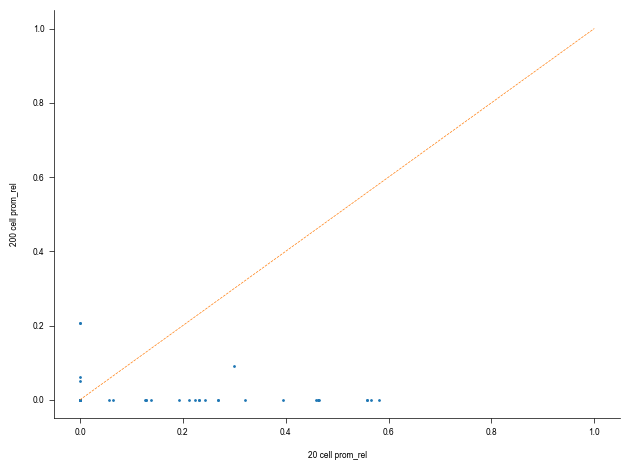

In [32]:
plt.plot([abs(i) for i in all_prom_rel_20], [abs(i) for i in all_prom_rel_200], linestyle="none", marker="o", markersize="1")
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.xlabel("20 cell prom_rel")
plt.ylabel("200 cell prom_rel")
plt.show()

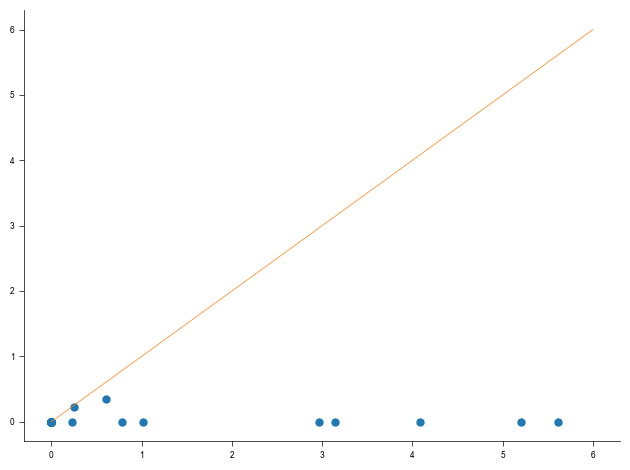

In [31]:
all_cell_results_df_20 = pd.read_pickle("/Users/kdreyer/Desktop/20_cell_all_cell_results_df_opt.pkl")
all_cell_results_df_200 = pd.read_pickle("/Users/kdreyer/Desktop/200_cell_all_cell_results_df_opt.pkl")
# display(all_cell_results_df_200)
prom_rel_200_vals = []
prom_rel_20_vals = []
for index, row in all_cell_results_df_200.iterrows():
    peak_rel_200 = pulse_200.calc_peak_rel(row["Rep_rel time series mean"])
    prom_rel_200 = pulse_200.calc_prominence_rel(row["Rep_rel time series mean"], peak_rel_200)
    prom_rel_200_vals.append(prom_rel_200)

    peak_rel_20 = pulse_20.calc_peak_rel(all_cell_results_df_20.loc[index, "Rep_rel time series mean"])
    prom_rel_20 = pulse_20.calc_prominence_rel(all_cell_results_df_20.loc[index, "Rep_rel time series mean"], peak_rel_20)
    prom_rel_20_vals.append(prom_rel_20)
    # if prom_rel_20 != 0 and prom_rel_200 == 0:
    #     t_pulse = pulse_20.calc_t_pulse(np.arange(0, 127, 1), all_cell_results_df_20.loc[index, "Rep_rel time series mean"], peak_rel_20, prom_rel_20)
#         print(t_pulse)
plt.plot(prom_rel_20_vals, prom_rel_200_vals, linestyle="none", marker="o")
plt.plot([0, 6], [0, 6])
plt.show()


In [25]:
# plt.plot([abs(i) for i in all_prom_rel_20], [abs(i) for i in all_prom_rel_200], linestyle="none", marker="o")
# plt.plot([0, 6], [0, 6], linestyle="dashed")
# plt.xlabel("20 cell prom_rel")
# plt.ylabel("200 cell prom_rel")
# plt.show()
pulse_single_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_5/"
all_obj_fname = "all_objectives.pkl"
all_circuits_fname = "all_circuits.pkl"
all_obj = pd.read_pickle(pulse_single_path+all_obj_fname)
with open(pulse_single_path+all_circuits_fname, "rb") as fid:
    all_circuits = pickle.load(fid)
all_obj = abs(all_obj)
# print(all_obj)
unique_obj, unique_indices = np.unique(all_obj, axis=0,
                                return_index=True)
unique_obj_df = pd.DataFrame(unique_obj, columns=["t_pulse","prominence_rel"])
select_subopt = unique_obj_df.copy()
select_subopt = select_subopt[select_subopt["prominence_rel"] >=5] 
select_circuits = all_circuits[select_subopt.index].flatten()
select_subopt["topology"] = select_circuits
# print(select_circuits)
# display(select_subopt)
print(select_subopt[select_subopt["t_pulse"] > 55])
# plt.plot(unique_obj[:, 0], unique_obj[:, 1], linestyle="none", marker="o")
# plt.plot(pulse_pareto_single["t_pulse"], pulse_pareto_single["prominence_rel"], linestyle="none", marker="o")
# plt.plot([i-2 for i in pulse_pareto_single["t_pulse"].tolist()], [i-2 for i in pulse_pareto_single["prominence_rel"].tolist()])
# plt.xlim(0, 20)
# plt.ylim(bottom=5)
# unique_circuits = all_circuits[unique_indices]
# select_subopt.to_pickle(pulse_single_path+"selected_unique_results.pkl")


      t_pulse  prominence_rel                                     topology
1731     58.0       28.493689  <define_circuit.Topo object at 0x151782aa0>
1732     58.0       28.493689  <define_circuit.Topo object at 0x151782d10>
1733     60.0       29.528967  <define_circuit.Topo object at 0x151782f50>
1734     60.0       29.528967  <define_circuit.Topo object at 0x1517831c0>
1735     62.0       27.710855  <define_circuit.Topo object at 0x1517833d0>
1736     64.0       26.866245  <define_circuit.Topo object at 0x1517835b0>
1738     68.0       12.489272  <define_circuit.Topo object at 0x1517839d0>
1750     90.0        8.924524  <define_circuit.Topo object at 0x151841390>
1774    122.0        6.884318  <define_circuit.Topo object at 0x156160670>


# Other test cases

### Amplifier Z matrix sampling all circuits vs. top pct

In [ ]:
plt.figure(figsize=(3, 3))
path_Z_sample = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/Amplifier_pop_vary_dose_Z_matrix_sampling_all/Z_matrix_sampling_for_CI.pkl"
with open(path_Z_sample, "rb") as fid:
    Z_sample = pickle.load(fid)
print(np.mean(Z_sample["ON_rel_std_error"]))
# print(max(Z_sample["ON_rel_std_error"])*0.5)
plt.hist(Z_sample["ON_rel_std_error"], bins=50)
# Z_sample["ON_rel_std_error"].plot.density(ind=1000)
plt.axvline(x=np.mean(Z_sample["ON_rel_std_error"]), label="mean", linestyle="dotted", color="k", linewidth=1.5)
plt.xlim([0, 0.85])
plt.xlabel("ON_rel std error")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(3, 3))
path_Z_sample2 = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-04-24_Amplifier_pop_vary_dose_Z_matrix_sampling/Z_matrix_sampling_for_CI.pkl"
with open(path_Z_sample2, "rb") as fid:
    Z_sample2 = pickle.load(fid)
# print(max(Z_sample2["ON_rel_std_error"]))
plt.hist(Z_sample2["ON_rel_std_error"], bins=20)
plt.axvline(x=max(Z_sample2["ON_rel_std_error"]), label="CI value", linestyle="dotted", color="k", linewidth=1.5)
plt.xlim([0, 0.85])
plt.xlabel("ON_rel std error")
plt.ylabel("Count")
plt.legend()
plt.show()

### Amplifier CI circuit comparisons: 20 cell vs 200 cell vs 2000 cell

In [ ]:
from define_circuit import Topo
from amplifier_problem import Amplifier

path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/selected_results_ON_rel_full_CI.pkl"
amp_CI = pd.read_pickle(path)
all_ON_rel_20 = amp_CI["ON_rel"].tolist()
all_ON_rel_200 = []
all_ON_rel_2000 = []
for index, row in amp_CI.iterrows():
    print("20 cell: ", all_ON_rel_20[index])
    topo = amp_CI.at[index, "Topology"]
    amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=True)
    [ON_rel_200, all_cells_dict_200] = amp_problem_200.func(topo)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)

    amp_problem_2000 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=42, single_cell_tracking=True)
    [ON_rel_2000, all_cells_dict_2000] = amp_problem_2000.func(topo)
    print("2000 cell: ", ON_rel_2000)
    all_ON_rel_2000.append(ON_rel_2000)
    print("***** topology ", index, " done *****")

In [4]:
amp_pop_comparison = {"20_cell": all_ON_rel_20, "200_cell": all_ON_rel_200, "2000_cell": all_ON_rel_2000}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x
# display(amp_pop_df_pos)

In [ ]:
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/"

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
# plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["2000_cell"], label="2000 cell model", linestyle="none", marker="o", markersize="4")
lower_bound = [63.11786016]*len(amp_pop_df_pos)
upper_bound = [63.50911412131601]*len(amp_pop_df_pos)
jittered_x.sort()
plt.fill_between(jittered_x, lower_bound, upper_bound, alpha=0.3, color="grey", zorder=3)
plt.xticks([])
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_CI.svg")

### Signal conditioner pareto circuit comparisons: 20 cell vs 200 cell vs 2000 cell

In [ ]:
from signal_conditioner_problem import SignalConditioner
path_sc = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_0/2024-09-05_results_analysis/selected_results_full_pareto_front.pkl"
sc_pareto = pd.read_pickle(path_sc)
# display(sc_pareto)

all_ON_rel_20 = sc_pareto["ON_rel"].tolist()
all_FI_rel_20 = sc_pareto["FI_rel"].tolist()
# num_topos = len(all_ON_rel_20)

all_ON_rel_200 = []
all_FI_rel_200 = []

# all_ON_rel_2000 = []
# all_FI_rel_2000 = []

for index, row in sc_pareto.iterrows():
    print("20 cell ON_rel, FI_rel: ", all_ON_rel_20[index], all_FI_rel_20[index])
    topo = sc_pareto.at[index, "Topology"]
    sc_problem_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=True)
    [[ON_rel_200, FI_rel_200], all_cells_dict_200] = sc_problem_200.func(topo)
    print("200 cell ON_rel, FI_rel: ", ON_rel_200, FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)

    # sc_problem_2000 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
    #                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
    #                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=42, single_cell_tracking=True)
    # [[ON_rel_2000, FI_rel_2000], all_cells_dict_2000] = sc_problem_2000.func(topo)
    # print("2000 cell ON_rel, FI_rel: ", ON_rel_2000, FI_rel_2000)
    # all_ON_rel_2000.append(ON_rel_2000)
    # all_FI_rel_2000.append(FI_rel_2000)    
    # print("***** topology ", index, " done *****")
    # topo_num = index + 1
    # if topo_num == num_topos:
    #     break

sc_pop_comparison = {"20_cell_ON_rel": all_ON_rel_20, "20_cell_FI_rel": all_FI_rel_20,
                     "200_cell_ON_rel": all_ON_rel_200, "200_cell_FI_rel": all_FI_rel_200,
                    #  "2000_cell_ON_rel": all_ON_rel_2000, "2000_cell_FI_rel": all_FI_rel_2000,
}
sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_0/2024-09-05_results_analysis/"
# sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons_20v200.csv")

In [ ]:
results_path = "/Users/kdreyer/Documents/Github/GraphGA/" + "GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/2024-05-02_Signal_Cond_pop_DsRED_inhibitor_original_hp_seed_0/"
obj_labels = ["ON_rel", "FI_rel"]
objectives_fname = "final_objectives_df.pkl"
pareto_front_objectives = pd.read_pickle(
    results_path+objectives_fname
)
selected_objectives = (
    pareto_front_objectives.drop_duplicates()
)
CI_metric_maxes = [0.7549563624285208, 0.004862470888440853]
obj1_CI = CI_metric_maxes[0]
obj2_CI = CI_metric_maxes[1]

upper_obj1 = np.abs(np.array(selected_objectives[obj_labels[0]]))
sorted_upper_idx = np.argsort(upper_obj1)
sorted_upper_obj1 = upper_obj1[sorted_upper_idx]

upper_obj1_plus = np.array([i+obj1_CI for i in upper_obj1])
sorted_upper_plus_idx = np.argsort(upper_obj1_plus)
sorted_upper_obj1_plus = upper_obj1_plus[sorted_upper_plus_idx]

lower_obj1 = np.array([i-obj1_CI for i in upper_obj1])
sorted_lower_idx = np.argsort(lower_obj1)
sorted_lower_obj1 = lower_obj1[sorted_lower_idx]

# upper_obj2 = np.array([i+obj2_CI_list[0] for i in (objectives[obj_labels[1]]*-1)])
upper_obj2 = np.abs(np.array(selected_objectives[obj_labels[1]]))
sorted_upper_obj2 = upper_obj2[sorted_upper_idx]

upper_obj2_plus = np.array([i+obj2_CI for i in upper_obj2])
sorted_upper_obj2_plus = upper_obj2_plus[sorted_upper_plus_idx]

lower_obj2 = np.array([i-obj2_CI for i in upper_obj2])
sorted_lower_obj2 = lower_obj2[sorted_lower_idx]

xfill = np.sort(np.concatenate([upper_obj1, lower_obj1]))
xfill_plus = np.sort(np.concatenate([upper_obj1_plus, lower_obj1]))

y1fill = np.interp(xfill, sorted_upper_obj1, sorted_upper_obj2)
y2fill = np.interp(xfill, sorted_lower_obj1, sorted_lower_obj2)
y2_plus_fill = np.interp(xfill_plus, sorted_lower_obj1, sorted_lower_obj2)
y1_plus_fill = np.interp(xfill_plus, sorted_upper_obj1_plus, sorted_upper_obj2_plus)
plt.figure(figsize=(5,5))
# plt.fill_between(xfill, y1fill, y2fill, alpha=0.3, color="grey", zorder=3)
plt.fill_between(xfill_plus, y1_plus_fill, y2_plus_fill, alpha=0.1, color="blue", zorder=1)
plt.plot(sc_pop_df_pos["20_cell_ON_rel"], sc_pop_df_pos["20_cell_FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="2", zorder=0)
plt.plot(sc_pop_df_pos["200_cell_ON_rel"], sc_pop_df_pos["200_cell_FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="2", zorder=1)
# plt.plot(sc_pop_df_pos["2000_cell_ON_rel"], sc_pop_df_pos["2000_cell_FI_rel"], label="2000 cell model", linestyle="none", marker="o", markersize="2")
# plt.legend()
# plt.xlim(left=40)
# plt.ylim(top=0.6)
# ax.plot(all_objectives[:, 0], all_objectives[:, 1], linestyle="none", 
#         marker="o", markersize=1, color="black", zorder=1)
plt.xlabel(obj_labels[0])
plt.ylabel(obj_labels[1])
plt.show()
# plt.savefig(results_path+"20vs200_cell_CI.svg", bbox_inches="tight")

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/unique_objectives.pkl"

unique_objs = pd.read_pickle(path).flatten()
sorted_objs = np.abs(np.sort(unique_objs))
# print(sorted_objs)
gte_2pct = [i for i in sorted_objs if i >= 62.23882]
print(gte_2pct)

In [ ]:
path_obj = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_single_cell_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_3/final_objectives_df.pkl"
path_circuit = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_single_cell_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_3/final_population.pkl"

objs = pd.read_pickle(path_obj)
circuits = pd.read_pickle(path_circuit)
# circuits[1][0].plot_graph()
# display(objs)
display(objs[objs["type"] == "Inhibitors"])

## Amplifier and signal conditioner post-facto 20v200 cell model comparison

### Amplifier

In [35]:
amp_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
obj_fname = "unique_objectives.pkl"
circuit_fname = "unique_circuits.pkl"
with open(amp_pop_path+obj_fname, "rb") as fid:
    amp_pop20_obj = pickle.load(fid)
amp_pop20_obj = abs(amp_pop20_obj.flatten())
with open(amp_pop_path+circuit_fname, "rb") as fid:
    amp_pop20_circuits = pickle.load(fid)
amp_pop20_circuits = amp_pop20_circuits.flatten()

selected_obj_idx_mid = np.where(
    np.logical_and(
        amp_pop20_obj > 37, 
        amp_pop20_obj < 42))[0]
selected_unique_obj_mid = amp_pop20_obj[selected_obj_idx_mid]
selected_unique_circuits_mid = amp_pop20_circuits[selected_obj_idx_mid]

selected_obj_idx_low = np.where(
        amp_pop20_obj < 20
        )[0]
selected_unique_obj_low = amp_pop20_obj[selected_obj_idx_low]
selected_unique_circuits_low = amp_pop20_circuits[selected_obj_idx_low]
print(len(selected_unique_circuits_mid))

102


#### mid-range ON_rel

In [ ]:
amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
for i, circuit in enumerate(selected_unique_circuits_mid):
    print("20 cell: ", selected_unique_obj_mid[i])
    ON_rel_200 = amp_problem_200.func(circuit)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    print("topology", i, " done")
    print("")


amp_pop_comparison = {"20_cell": selected_unique_obj_mid, "200_cell": all_ON_rel_200}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = amp_pop_path + "pop200_comparison_mid-range/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")


In [ ]:
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xticks([])
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_ON_rel_mid.svg")

#### low ON_rel

In [ ]:
amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
for i, circuit in enumerate(selected_unique_circuits_low):
    print("20 cell: ", selected_unique_obj_low[i])
    ON_rel_200 = amp_problem_200.func(circuit)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    print("topology", i, " done")
    print("")


amp_pop_comparison = {"20_cell": selected_unique_obj_low, "200_cell": all_ON_rel_200}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = amp_pop_path + "pop200_comparison_low/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xticks([])
plt.ylabel("ON_rel")
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_ON_rel_low.svg")

### Signal conditioner

In [33]:
sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Original_hyperparams/SC_original_hp_seed_0/"
obj_fname = "unique_objectives_df.pkl"
circuit_fname = "unique_circuits.pkl"

unique_obj_df = pd.read_pickle(sc_pop_path+obj_fname).abs()
with open(sc_pop_path+circuit_fname, "rb") as fid:
    sc_pop20_circuits = pickle.load(fid)
sc_pop20_circuits = sc_pop20_circuits.flatten()
# display(unique_obj_df)

selected_obj_mid = unique_obj_df[
    (unique_obj_df["ON_rel"] < 15) &
    ((unique_obj_df["FI_rel"] > 0.7) & (unique_obj_df["FI_rel"] < 0.8))
]
unique_obj_mid = selected_obj_mid.copy()
unique_ON_rel_mid = unique_obj_mid["ON_rel"].tolist()
unique_FI_rel_mid = unique_obj_mid["FI_rel"].tolist()

selected_obj_idx_m = selected_obj_mid.index.tolist()
selected_circuits_mid = sc_pop20_circuits[selected_obj_idx_m]

selected_obj_low = unique_obj_df[
    ((unique_obj_df["ON_rel"] > 15) & (unique_obj_df["ON_rel"] < 30)) &
    ((unique_obj_df["FI_rel"] > 0.4) & (unique_obj_df["FI_rel"] < 0.5))
]

unique_obj_low = selected_obj_low.copy()
unique_ON_rel_low = unique_obj_low["ON_rel"].tolist()
unique_FI_rel_low = unique_obj_low["FI_rel"].tolist()

selected_obj_idx_l = selected_obj_low.index.tolist()
selected_circuits_low = sc_pop20_circuits[selected_obj_idx_l]

# plt.plot(unique_obj_df["ON_rel"], unique_obj_df["FI_rel"],  linestyle="none", marker="o")
# plt.plot(unique_obj_mid["ON_rel"], unique_obj_mid["FI_rel"], linestyle="none", marker="o")
# plt.plot(unique_obj_low["ON_rel"], unique_obj_low["FI_rel"], linestyle="none", marker="o")


#### signal conditioner mid-range objs

In [ ]:
signal_cond_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True,
                                    DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None,
                                    probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                                    num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
all_FI_rel_200 = []
for i, circuit in enumerate(selected_circuits_mid):
    print("20 cell ON_rel, FI_rel: ", unique_ON_rel_mid[i], unique_FI_rel_mid[i])
    [ON_rel_200, FI_rel_200] = signal_cond_200.func(circuit)
    print("200 cell ON_rel, FI_rel: ", -ON_rel_200, -FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)
    print("topology", i, " done")
    print("")


sc_pop_comparison = {"20_cell ON_rel": unique_ON_rel_mid,
                     "20_cell FI_rel": unique_FI_rel_mid,
                     "200_cell ON_rel": all_ON_rel_200,
                     "200_cell FI_rel": all_FI_rel_200}


sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = sc_pop_path + "pop200_comparison_mid/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(sc_pop_df_pos["20_cell ON_rel"], sc_pop_df_pos["20_cell FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(sc_pop_df_pos["200_cell ON_rel"], sc_pop_df_pos["200_cell FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xlabel("ON_rel")
plt.ylabel("FI_rel")
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_objs_mid.svg")

#### signal conditioner low objs (FI_rel)

In [ ]:
signal_cond_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True,
                                    DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None,
                                    probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                                    num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
all_FI_rel_200 = []
for i, circuit in enumerate(selected_circuits_low):
    print("20 cell ON_rel, FI_rel: ", unique_ON_rel_low[i], unique_FI_rel_low[i])
    [ON_rel_200, FI_rel_200] = signal_cond_200.func(circuit)
    print("200 cell ON_rel, FI_rel: ", -ON_rel_200, -FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)
    print("topology", i, " done")
    print("")


sc_pop_comparison = {"20_cell ON_rel": unique_ON_rel_low,
                     "20_cell FI_rel": unique_FI_rel_low,
                     "200_cell ON_rel": all_ON_rel_200,
                     "200_cell FI_rel": all_FI_rel_200}


sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = sc_pop_path + "pop200_comparison_low/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(sc_pop_df_pos["20_cell ON_rel"], sc_pop_df_pos["20_cell FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(sc_pop_df_pos["200_cell ON_rel"], sc_pop_df_pos["200_cell FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xlabel("ON_rel")
plt.ylabel("FI_rel")
plt.legend()
# plt.show()
# plt.savefig(path_save+"20vs200_cell_objs_low.svg")

## CI analysis 

### Use in_dict to compare two circuits

In [36]:
def sort_in_dict(in_dict):
    sorted_in_dict = {}
    for key, val in in_dict.items():
    # print(key, val)
        val_sorted = {}
        for subkey, subval in val.items():
            subval.sort()
        #     print(subkey, subval)
            val_sorted.update({subkey: subval})
        sorted_in_dict.update({key: val_sorted})
    return sorted_in_dict


def generalize_in_dict(in_dict):
    in_dict_general = {}
    # format of keys: "part|regulator1|regulator2|..."
    for key, value in in_dict.items():
        i = 0
        key_reg = key[0]
        if len(value["P"]) > 0:
            key_reg += "P"
        if len(value["Z"]) > 0:
            key_regZ = ""
            for Zreg in value["Z"]:
                if Zreg == key:
                    key_regZ += "A"
                else:
                    key_regZ += "Z"
            key_regZ = "".join(sorted(key_regZ))
            key_reg += key_regZ
        if len(value["I"]) > 0:
            key_regI = ""
            for Ireg in value["I"]:
                if Ireg == key:
                    key_regI += "A"
                else:
                    key_regI += "I"
            key_regI = "".join(sorted(key_regI))
            key_reg += key_regI
        in_dict_general.update({key_reg: value})
    
    return in_dict_general

### CI topologies

/var/folders/ns/9zdlrc210px6q49986n73k1h0000gn/T/ipykernel_73963/1072260963.py:128: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))


,opt_0_var_objs,opt_1_var_objs,opt_2_var_objs,opt_3_var_objs,opt_4_var_objs,opt_5_var_objs
0,NaN,NaN,63.221052,NaN,NaN,63.149296
1,NaN,NaN,63.198963,NaN,NaN,NaN


,opt_topo,column_name,ON_rel
2,opt_2_var_objs,0,63.221052
5,opt_5_var_objs,0,63.149296
8,opt_2_var_objs,1,63.198963


/var/folders/ns/9zdlrc210px6q49986n73k1h0000gn/T/ipykernel_73963/1072260963.py:186: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors, s=20, legend=False)


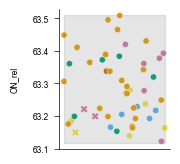

In [8]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
Z_sampling_path = "2024-08-23_results_analysis_full_CI/"
CI_fname = "selected_results_ON_rel_full_CI.pkl"
amp_CI = pd.read_pickle(path+Z_sampling_path+CI_fname)

objs0 = []
in_dict0 = {'Z6': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6', 'Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []}
}
sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = []
in_dict1 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict2 = sort_in_dict(in_dict2)

objs3 = []
in_dict3 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
sorted_in_dict3 = sort_in_dict(in_dict3)

objs4 = [] #vermillion
in_dict4 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict4 = sort_in_dict(in_dict4)

objs5 = []
in_dict5 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict5 = sort_in_dict(in_dict5)


in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
# print(in_dict2_general.keys())
in_dict3_general = generalize_in_dict(in_dict3)
# print(in_dict3_general.keys())
in_dict4_general = generalize_in_dict(in_dict4)
# print(in_dict4_general.keys())
in_dict5_general = generalize_in_dict(in_dict5)
# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2, sorted_in_dict3, sorted_in_dict4, sorted_in_dict5]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general, in_dict3_general, in_dict4_general, in_dict5_general]
keys_list = [d.keys() for d in dict_list_general]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_objs": [],
    "opt_0_doses": [],
    "opt_1_topology": [],
    "opt_1_objs": [],
    "opt_1_doses": [],
    "opt_2_topology": [],
    "opt_2_objs": [],
    "opt_2_doses": [],
    "opt_3_topology": [],
    "opt_3_objs": [],
    "opt_3_doses": [],
    "opt_4_topology": [],
    "opt_4_objs": [],
    "opt_4_doses": [],
    "opt_5_topology": [],
    "opt_5_objs": [],
    "opt_5_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_objs": [],
    "opt_0_var_doses": [],
    "opt_1_var_topology": [],
    "opt_1_var_objs": [],
    "opt_1_var_doses": [],
    "opt_2_var_topology": [],
    "opt_2_var_objs": [],
    "opt_2_var_doses": [],
    "opt_3_var_topology": [],
    "opt_3_var_objs": [],
    "opt_3_var_doses": [],
    "opt_4_var_topology": [],
    "opt_4_var_objs": [],
    "opt_4_var_doses": [],
    "opt_5_var_topology": [],
    "opt_5_var_objs": [],
    "opt_5_var_doses": [],
}

for index, row in amp_CI.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Parts order"]
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_objs"].append(row["ON_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        variant_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        opt_variants["opt_"+str(variant_idx)+"_var_topology"].append(row["Topology"])
        opt_variants["opt_"+str(variant_idx)+"_var_objs"].append(row["ON_rel"])
        opt_variants["opt_"+str(variant_idx)+"_var_doses"].append(row["Topology"].dose)


    # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
# opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
# opt_circuits_df.to_csv(path+Z_sampling_path+"labeled_CI_circuits.csv")
# opt_variants_df.to_csv(path+Z_sampling_path+"labeled_CI_circuit_variants.csv")
opt_objs = opt_circuits_df.drop(list(
    opt_circuits_df.filter(regex="topology")
    ), axis=1)
opt_objs = opt_objs.drop(list(
    opt_circuits_df.filter(regex="doses")
    ), axis=1)
# display(opt_objs)
# display(opt_circuits_df_nonan)
opt_variant_objs = opt_variants_df.drop(list(
    opt_variants_df.filter(regex="topology")
    ), axis=1)
opt_variant_objs = opt_variant_objs.drop(list(
    opt_variants_df.filter(regex="doses")
    ), axis=1)
display(opt_variant_objs)
# opt_circuits_df.to_pickle(path+"topologies_in_CI.pkl")
# opt_circuits_df.to_csv(path+"topologies_in_CI.csv")
# opt_variants_df.to_pickle(path+"topology_variants_in_CI.pkl")
# opt_variants_df.to_csv(path+"topology_variants_in_CI.csv")

opt_objs_T = opt_objs.transpose()
opt_objs_T["opt_topo"] = opt_objs_T.index
# display(opt_objs_T)
opt_variant_objs_T = opt_variant_objs.transpose()
opt_variant_objs_T["opt_topo"] = opt_variant_objs_T.index

opt_objs_plot = pd.melt(frame=opt_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_objs_plot.dropna(inplace=True)

opt_variant_objs_plot = pd.melt(frame=opt_variant_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_variant_objs_plot.dropna(inplace=True)

x_vals = [0]*len(opt_objs_plot)
# print(len(x_vals))
np.random.seed(0)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
opt_objs_plot["jittered_x"] = jittered_x
display(opt_variant_objs_plot)

x_vals_var = [0]*len(opt_variant_objs_plot)
jittered_x_var = x_vals_var + np.random.rand(
    len(x_vals_var))
opt_variant_objs_plot["jittered_x"] = jittered_x_var
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)

fig, ax = plt.subplots(1, 1, figsize=(1.9, 1.75))
sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors, s=20, legend=False)
sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=[colors[2], colors[5]], marker= "X", s=30, legend=False)
lower_bound = [63.11786016]*len(opt_objs_plot)
upper_bound = [63.50911412131601]*len(opt_objs_plot)
jittered_x.sort()
ax.fill_between(jittered_x, lower_bound, upper_bound, alpha=0.2, color="grey", zorder=3)
ax.set_xticks([])
ax.set_yticks([63.1, 63.2, 63.3, 63.4, 63.5])
ax.set_xlabel("")
plt.show()
# plt.savefig(path+"topologies_in_CI.svg")

### Sub-opt topologies

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
topologies_fname = "unique_circuits.pkl"
objs_fname = "unique_objectives.pkl"

with open(path+topologies_fname, "rb") as fid:
    unique_topos = pickle.load(fid)
unique_topos = unique_topos.flatten()
with open(path+objs_fname, "rb") as fid:
    unique_objs = pickle.load(fid)
unique_objs = abs(unique_objs.flatten())
unique_results = np.column_stack((unique_topos, unique_objs))
# print(unique_results)

unique_results_df = pd.DataFrame(data=unique_results, columns=["Topology", "ON_rel"])
unique_results_subopt = unique_results_df[unique_results_df["ON_rel"] < 63.11786016]
display(unique_results_subopt)

In [ ]:
objs0 = [] #orange
in_dict0 = {'Z6': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6', 'Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []}
}
topo0_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo0 = nx.DiGraph()
topo0.add_edges_from(topo0_edges)
shortest_path0 = nx.shortest_path(topo0, "P1", "Rep")
# print(shortest_path0)
sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = [] #, sky_blue, pink_, bluish_green, vermillion, yellow_,
in_dict1 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
topo1_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z2', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo1 = nx.DiGraph()
topo1.add_edges_from(topo1_edges)
shortest_path1 = nx.shortest_path(topo1, "P1", "Rep")
# print(shortest_path1)
sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo2_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z2'), ('Z2', 'Z6')]
topo2 = nx.DiGraph()
topo2.add_edges_from(topo2_edges)
shortest_path2 = nx.shortest_path(topo2, "P1", "Rep")
# print(shortest_path2)
sorted_in_dict2 = sort_in_dict(in_dict2)

objs2_Z7 = []
in_dict2_Z7 = {'Z6': {'P': [], 'Z': ['Z7', 'Z6'], 'I': []},
            'Z7': {'P': ['P1'], 'Z': ['Z7', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo2_Z7_edges = [('P1', 'Z7'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z7'), ('Z7', 'Z7'), ('Z7', 'Z6')]
topo2_Z7 = nx.DiGraph()
topo2_Z7.add_edges_from(topo2_Z7_edges)
shortest_path2_Z7 = nx.shortest_path(topo2_Z7, "P1", "Rep")
sorted_in_dict2 = sort_in_dict(in_dict2)
sorted_in_dict2_Z7 = sort_in_dict(in_dict2_Z7)

objs3 = []
in_dict3 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
topo3_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo3 = nx.DiGraph()
topo3.add_edges_from(topo3_edges)
shortest_path3 = nx.shortest_path(topo3, "P1", "Rep")
sorted_in_dict3 = sort_in_dict(in_dict3)

objs4 = []
in_dict4 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo4_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z6')]
topo4 = nx.DiGraph()
topo4.add_edges_from(topo4_edges)
shortest_path4 = nx.shortest_path(topo4, "P1", "Rep")
sorted_in_dict4 = sort_in_dict(in_dict4)

objs5 = []
in_dict5 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo5_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z2', 'Z2'), ('Z2', 'Z6')]
topo5 = nx.DiGraph()
topo5.add_edges_from(topo5_edges)
shortest_path5 = nx.shortest_path(topo5, "P1", "Rep")
sorted_in_dict5 = sort_in_dict(in_dict5)


in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
# print(in_dict2_general.keys())
in_dict2_Z7_general = generalize_in_dict(in_dict2_Z7)
# print(in_dict2_general.keys())
in_dict3_general = generalize_in_dict(in_dict3)
# print(in_dict3_general.keys())
in_dict4_general = generalize_in_dict(in_dict4)
# print(in_dict4_general.keys())
in_dict5_general = generalize_in_dict(in_dict5)
# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2, sorted_in_dict3, sorted_in_dict4, sorted_in_dict5]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general, in_dict3_general, in_dict4_general, in_dict5_general]
keys_list = [d.keys() for d in dict_list_general]
shortest_path_list = [shortest_path0, shortest_path1, shortest_path2, shortest_path3, shortest_path4, shortest_path5]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_objs": [],
    "opt_0_doses": [],
    "opt_1_topology": [],
    "opt_1_objs": [],
    "opt_1_doses": [],
    "opt_2_topology": [],
    "opt_2_objs": [],
    "opt_2_doses": [],
    "opt_2_Z7_topology": [],
    "opt_2_Z7_objs": [],
    "opt_2_Z7_doses": [],
    "opt_3_topology": [],
    "opt_3_objs": [],
    "opt_3_doses": [],
    "opt_4_topology": [],
    "opt_4_objs": [],
    "opt_4_doses": [],
    "opt_5_topology": [],
    "opt_5_objs": [],
    "opt_5_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_objs": [],
    "opt_0_var_doses": [],
    "opt_1_var_topology": [],
    "opt_1_var_objs": [],
    "opt_1_var_doses": [],
    "opt_2_var_topology": [],
    "opt_2_var_objs": [],
    "opt_2_var_doses": [],
    "opt_3_var_topology": [],
    "opt_3_var_objs": [],
    "opt_3_var_doses": [],
    "opt_4_var_topology": [],
    "opt_4_var_objs": [],
    "opt_4_var_doses": [],
    "opt_5_var_topology": [],
    "opt_5_var_objs": [],
    "opt_5_var_doses": [],
}

for index, row in unique_results_subopt.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Topology"].in_dict
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_objs"].append(row["ON_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif sorted_in_dict == sorted_in_dict2_Z7:
        opt_circuits["opt_2_Z7_topology"].append(row["Topology"])
        opt_circuits["opt_2_Z7_objs"].append(row["ON_rel"])
        opt_circuits["opt_2_Z7_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        possible_variant = keys_list.index(row_in_dict_general.keys())
        topo_graph = row["Topology"].graph
        shortest_path = nx.shortest_path(topo_graph, "P1", "Rep")
        if len(shortest_path) == len(shortest_path_list[possible_variant]):
        #     print(row["Topology"].in_dict)
        #     print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        #     print("***")
            opt_variants["opt_"+str(possible_variant)+"_var_topology"].append(row["Topology"])
            opt_variants["opt_"+str(possible_variant)+"_var_objs"].append(row["ON_rel"])
            opt_variants["opt_"+str(possible_variant)+"_var_doses"].append(row["Topology"].dose)

    # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
# opt_variants_df_nonan = opt_variants_df.fillna(value="", inplace=False)
opt_objs = opt_circuits_df.drop(list(
    opt_circuits_df.filter(regex="topology")
    ), axis=1)
opt_objs = opt_objs.drop(list(
    opt_circuits_df.filter(regex="doses")
    ), axis=1)
opt_variant_objs = opt_variants_df.drop(list(
    opt_variants_df.filter(regex="topology")
    ), axis=1)
opt_variant_objs = opt_variant_objs.drop(list(
    opt_variants_df.filter(regex="doses")
    ), axis=1)

# display(opt_objs)
# display(opt_circuits_df_nonan)

# opt_circuits_df.to_pickle(path+"topologies_sub_opt.pkl")
# opt_circuits_df.to_csv(path+"topologies_sub_opt.csv")
# opt_variants_df.to_pickle(path+"topology_variants_sub_opt.pkl")
# opt_variants_df.to_csv(path+"topology_variants_sub_opt.csv")

opt_objs_T = opt_objs.transpose()
opt_objs_T["opt_topo"] = opt_objs_T.index
opt_variant_objs_T = opt_variant_objs.transpose()
opt_variant_objs_T["opt_topo"] = opt_variant_objs_T.index
# display(opt_objs_T)

opt_objs_plot = pd.melt(frame=opt_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_objs_plot.dropna(inplace=True)
# print(len(opt_objs_plot))
opt_variant_objs_plot = pd.melt(frame=opt_variant_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_variant_objs_plot.dropna(inplace=True)
# print(len(opt_variant_objs_plot))
x_vals = [0]*len(opt_objs_plot)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
opt_objs_plot["jittered_x"] = jittered_x
display(opt_objs_plot)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
plt.ylim([0, 65])
plt.show()

# x_vals_var = [0]*len(opt_variant_objs_plot)
# jittered_x_var = x_vals_var + np.random.rand(
#     len(x_vals_var))
# opt_variant_objs_plot["jittered_x"] = jittered_x_var
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
# plt.ylim([0, 65])
# plt.show()
# opt_variant_objs_low_plot = opt_variant_objs_plot[opt_variant_objs_plot["ON_rel"] < 60]
# print(len(opt_variant_objs_low_plot))


# opt_objs_low_plot = opt_objs_plot[opt_objs_plot["ON_rel"] < 60]
# # display(opt_objs_low_plot)
# print(len(opt_objs_low_plot))

# x_vals = [0]*len(opt_objs_low_plot)
# jittered_x = x_vals + np.random.rand(
#     len(x_vals))
# opt_objs_low_plot["jittered_x"] = jittered_x
# # # display(opt_objs_plot)
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_objs_low_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
# plt.ylim([0, 65])
# plt.show()

### Find objectives that fall within pareto CI

In [ ]:
# sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Original_hyperparams/SC_original_hp_seed_0/"
sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Single_cell_model_opt_hyperparams/SC_original_hp_seed_0/"

obj_fname = "unique_objectives_df.pkl"
pareto_fname = "final_objectives_df.pkl"

circuit_fname = "unique_circuits.pkl"
CI_path = "2024-09-06_Z_matrix_sampling/Z_matrix_sampling_for_CI.pkl"

pareto_front_objectives = pd.read_pickle(
    sc_pop_path+pareto_fname
)
selected_objectives = (
    pareto_front_objectives.drop_duplicates()
)
display(selected_objectives)
unique_obj_df = pd.read_pickle(sc_pop_path+obj_fname).abs()
with open(sc_pop_path+circuit_fname, "rb") as fid:
    sc_pop20_circuits = pickle.load(fid)
sc_pop20_circuits = sc_pop20_circuits.flatten()

CI_sampling = pd.read_pickle(sc_pop_path+CI_path)
# display(CI_sampling)
print(max(CI_sampling["ON_rel_std_error"]), max(CI_sampling["FI_rel_std_error"]))


In [ ]:
obj_labels = ["ON_rel", "FI_rel"]
CI_metric_maxes = [0.7549563624285208, 0.004862470888440853]
obj1_CI = CI_metric_maxes[0]
obj2_CI = CI_metric_maxes[1]

upper_obj1 = np.abs(np.array(selected_objectives[obj_labels[0]]))
sorted_upper_idx = np.argsort(upper_obj1)
sorted_upper_obj1 = upper_obj1[sorted_upper_idx]

lower_obj1 = np.array([i-obj1_CI for i in upper_obj1])
sorted_lower_idx = np.argsort(lower_obj1)
sorted_lower_obj1 = lower_obj1[sorted_lower_idx]

upper_obj2 = np.abs(np.array(selected_objectives[obj_labels[1]]))
sorted_upper_obj2 = upper_obj2[sorted_upper_idx]

lower_obj2 = np.array([i-obj2_CI for i in upper_obj2])
sorted_lower_obj2 = lower_obj2[sorted_lower_idx]

xfill = np.sort(np.concatenate([upper_obj1, lower_obj1]))

y1fill = np.interp(xfill, sorted_upper_obj1, sorted_upper_obj2)
y2fill = np.interp(xfill, sorted_lower_obj1, sorted_lower_obj2)

unique_obj_df_CI = unique_obj_df[
    (unique_obj_df["FI_rel"] >= np.interp(unique_obj_df["ON_rel"], xfill, y2fill)) &
    (unique_obj_df["FI_rel"] <= np.interp(unique_obj_df["ON_rel"], xfill, y1fill))
]

CI_idx = unique_obj_df_CI.index.tolist()
unique_circuits_CI = sc_pop20_circuits[CI_idx]
# display(unique_obj_df)

plt.plot(unique_obj_df["ON_rel"], unique_obj_df["FI_rel"], linestyle="none", marker="o", markersize="2", color="grey")
plt.plot(unique_obj_df_CI["ON_rel"], unique_obj_df_CI["FI_rel"], linestyle="none", marker="o", markersize="2")
plt.ylim([0.44, 0.975])
plt.plot(xfill, y1fill, linewidth="2")
plt.plot(xfill, y2fill, linewidth="2")

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_opt_stdev_ngen50/run2_ngen80/SC_opt_hp_ngen50_run2_seed_7/"
fname = "all_objectives.pkl"
all_objs = pd.read_pickle(path+fname)
unique_objs = abs(np.unique(all_objs, axis=0))
# print(len(unique_objs))
unique_obj_df = pd.DataFrame(unique_objs, columns=["ON_rel", "FI_rel"])
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
sns.scatterplot(data=unique_obj_df, x="ON_rel", y="FI_rel", color="k", ax=ax, s=8, linewidth=0.0)
plt.savefig(path+"unique_obj_scatter.svg")

In [ ]:
path = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/2024-10-06_Pulse_single_cell_DsRED_3_obj_original_hp_seed_9/hypervolumes.pkl"
with open(path, "rb") as fid:
    hvs = pickle.load(fid)

print(hvs)

408
45.89854218733082


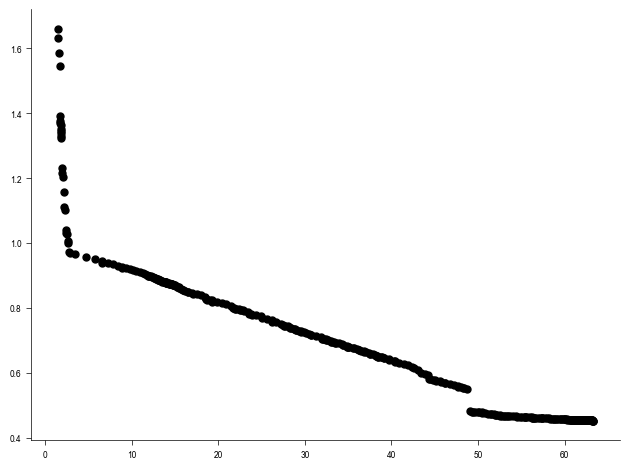

In [3]:
from pymoo.indicators.hv import HV
ref_point = np.array([0, 0])
hv = HV(ref_point=ref_point)

path_sigcond = "/Users/kdreyer/Documents/Github/GraphGA/combinatorial_search/sig_cond_pareto_dsred1.pkl"
path_GA0 = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Original_hyperparams/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_original_hps_ngen120_seed_5/final_objectives_df.pkl"
path_GA3 = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_max_hv_ngen50/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_opt_hps_run4_seed_3/final_objectives_df.pkl"
path_GA4 = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_max_hv_ngen50/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_opt_hps_run4_seed_4/final_objectives_df.pkl"
# path_GA6 = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_max_hv/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_opt_hps_run4_seed_6/final_objectives_df.pkl"

sig_cond_pareto = pd.read_pickle(path_sigcond)
hv_combo = hv(sig_cond_pareto)
print(len(sig_cond_pareto))
print(hv_combo)
sig_cond_GA0 = pd.read_pickle(path_GA0)
# sig_cond_GA1 = pd.read_pickle(path_GA1)
sig_cond_GA3 = pd.read_pickle(path_GA3)
sig_cond_GA4 = pd.read_pickle(path_GA4)
# sig_cond_GA6 = pd.read_pickle(path_GA6)

# print(sig_cond_GA)
plt.plot(abs(sig_cond_pareto[:, 0]), abs(sig_cond_pareto[:, 1]), linestyle="none", marker="o", markersize="5", color="k")
# plt.plot(abs(sig_cond_GA3["ON_rel"]), abs(sig_cond_GA3["FI_rel"]), linestyle="none", marker="o", markersize="5", fillstyle="none", color="red")

# plt.plot(abs(sig_cond_GA0["ON_rel"]), abs(sig_cond_GA0["FI_rel"]), linestyle="none", marker="o", markersize="5", fillstyle="none", color="green")
# plt.ylim(0.9, 1.7)
# plt.xlim(0, 5)
# plt.plot(abs(sig_cond_GA4["ON_rel"]), abs(sig_cond_GA4["FI_rel"]), linestyle="none", marker="o", markersize="5", fillstyle="none", color="red")
# plt.plot(abs(sig_cond_GA6["ON_rel"]), abs(sig_cond_GA6["FI_rel"]), linestyle="none", marker="o", markersize="3", fillstyle="none")

In [2]:
path_amp = "/Users/kdreyer/Documents/Github/GraphGA/combinatorial_search/ranked_obj_amp_dsred0.pkl"
path_amp_topo = "/Users/kdreyer/Documents/Github/GraphGA/combinatorial_search/ranked_topo_amp_dsred0.pkl"
amp_topo = pd.read_pickle(path_amp_topo)
# print(amp_topo.edge_list)
# amp_topo.plot_graph()
amp_obj = pd.read_pickle(path_amp)
amp_obj = abs(amp_obj)
print(amp_obj)

63.317931590906994


In [3]:
path_amp_GA= "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_single_cell/Original_hyperparams_vary_dose/Amplifier_single_cell_vary_dose_original_hp_seed_0/minimum_obj_all_gens.pkl"
amp_GA = pd.read_pickle(path_amp_GA)
print(min(amp_GA))

-63.31793159095933


In [ ]:
from pymoo.indicators.hv import HV
ref_point = np.array([126, 0, 0])
hv = HV(ref_point=ref_point)

path_pulse = "/Users/kdreyer/Documents/Github/GraphGA/combinatorial_search/pulse_pareto_3obj_dsred1.pkl"
path_GA0 = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Original_hyperparams/3_obj/run3_ngen100/2024-10-06_Pulse_single_cell_DsRED_3_obj_original_hp_seed_1/final_objectives_df.pkl"
pulse_pareto = pd.read_pickle(path_pulse)
hv_combo = hv(pulse_pareto)
# print(hv_combo)
# print(len(pulse_pareto))
pulse_GA = pd.read_pickle(path_GA0)
# display(pulse_GA.drop_duplicates())
display(pulse_GA[pulse_GA["t_pulse"] == 0])
display(pulse_GA)
fig = plt.figure(figsize= (4, 4))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=abs(pulse_pareto[:, 0]), ys=abs(pulse_pareto[:, 1]),zs=abs(pulse_pareto[:, 2]))
ax.scatter(xs=abs(pulse_GA["t_pulse"]), ys=abs(pulse_GA["peak_rel"]),zs=abs(pulse_GA["prominence_rel"]))

ax.view_init(elev=10, azim=-115)

prom_ga = abs(pulse_GA["prominence_rel"])
prom_ga = [round(i, 5) for i in prom_ga]
prom_combo = abs(pulse_pareto[:, 2])
prom_combo = [round(i, 5) for i in prom_combo]
same_prom = list(set(prom_ga) & set(prom_combo))
same_prom_idx_ga = [prom_ga.index(i) for i in same_prom]
same_prom_idx_combo = [prom_combo.index(i) for i in same_prom]
# print(len(list(set(prom_ga) & set(prom_combo))))
# print(same_prom_idx_ga)
# print(pulse_pareto[same_prom_idx_combo])
# display(pulse_GA.iloc[same_prom_idx_ga])

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/Fixed_pop_t_pulse_max_hv/run3_ngen130/2024-10-05_Pulse_single_cell_opt_hp_ngen130_seed_9/final_objectives_df.pkl"

t_pulse = pd.read_pickle(path)
display(t_pulse[t_pulse["t_pulse"] == 0])

In [31]:
from pulse_generator_problem import PulseGenerator
pulse_prob_Z1_Z2= PulseGenerator("P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True,
                              DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None,
                              probability_mutation=None, mutate_dose=True, pop=True, num_processes=8,
                              max_time=126, single_cell_tracking=False, obj_labels=["t_pulse", "peak_rel", "prominence_rel"])

# path_pulse_pareto = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/2024-10-08_Pulse_pop_DsRED_frac_pulse_ZF1_ZF2_seed_0/2024-10-08_results_analysis/selected_results_full_pareto_front.pkl"
path_all = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/2024-10-08_Pulse_pop_DsRED_frac_pulse_ZF1_ZF2_ngen80_seed_0/all_circuits.pkl"
path_all_obj = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/2024-10-08_Pulse_pop_DsRED_frac_pulse_ZF1_ZF2_ngen80_seed_0/all_objectives.pkl"

# path_all_obj = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/2024-10-08_Pulse_pop_DsRED_frac_pulse_ZF1_ZF2_ngen80_seed_0/unique_objectives_df.pkl"
# pulse_selected = pd.read_pickle(path_pulse_pareto)
pulse_all = pd.read_pickle(path_all)
pulse_all_obj = pd.read_pickle(path_all_obj)
# pulse_unique_obj = pulse_all_obj.drop_duplicates()
# unique_idx = pulse_unique_obj.index.tolist()
# display(pulse_unique_obj)
pulse_all = pulse_all.flatten()
# all_circuits_unique = pulse_all[unique_idx]
# print(all_circuits_unique)
# pulse_outdated = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Pulse_seed_pop_DsRED_inhibitor/ZF1_ZF2_only/2024-03-07_Pulse_pop_DsRED_inhibitor_3obj_126h_ZF1_ZF2_new_dose_terms_seed_0/2024-09-23_results_analysis/selected_results_low_t_pulse.pkl"
# outdated = pd.read_pickle(pulse_outdated)
# frac_pulse_list = pulse_unique_obj["frac_pulse"].tolist()
# prom_pulse_list = pulse_unique_obj["prominence_rel"].tolist()
t_pulse_list = []
peak_rel_list = []
prom_rel_list = []
topo_list = []
for i, topo in enumerate(pulse_all):
    if len(topo.edge_list) == 6:
        if pulse_all_obj[i][0] != 0 and pulse_all_obj[i][1] != 0:
            topo_list.append(topo.dose)
            # print(topo.dose)
            # print(pulse_all_obj[i])
print(len(topo_list))
doses_exp = []
for doses in topo_list:
    if doses == {'I2': 25, 'Z1': 70, 'Rep': 200}: #, {'I2': 25, 'Z1': 70, 'Rep': 200}, {'I2': 20, 'Z1': 50, 'Rep': 200}, {'I2': 25, 'Z1': 65, 'Rep': 200}, {'I2': 30, 'Z1': 75, 'Rep': 200}, {'I2': 25, 'Z1': 65, 'Rep': 200}]:
        print(doses)
        # doses_exp.append(doses)
# list({v['Rep']:v for v in doses_exp}.values())
    # [t_pulse, peak_rel, prom_rel] = pulse_prob_Z1_Z2.func_obj_3obj(topo)
    # t_pulse_list.append(t_pulse)
    # peak_rel_list.append(abs(peak_rel))
    # prom_rel_list.append(abs(prom_rel))
    # print(t_pulse, peak_rel, prom_rel)


#     # [frac_pulse, pulse_prom_rel]  = pulse_problem.func_obj_frac_pulse(circuit)
#     [t_pulse, peak_rel, prom_rel] = pulse_problem.func_obj_3obj(circuit)
#     # print(t_pulse, prom_rel)
#     # peak_rel = abs(peak_rel)
#     # pulse_prominence_rel = abs(pulse_prom_rel)
#     # frac_pulse = abs(frac_pulse)
#     # print(frac_pulse, pulse_prominence_rel, row["t_pulse"])
#     # t_pulse_list.append(t_pulse)
#     # peak_list.append(peak_rel)
#     # prom_list.append(prominence_rel)
#     if t_pulse < 126:
#         print(t_pulse, peak_rel, prom_rel)#, frac_pulse)

# 10 -0.8630219893328684 -0.3703125448827806
# 12 -0.7094098020763517 -0.18423179414241309
# 126 -22.628666960183835 0
# 126 -22.973823478977742 0
# 24 -2.6239987430686567 -0.3379693065147995

6409


In [4]:
sort_t_p = sorted(t_pulse_list)
print(sort_t_p)

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 16, 17, 17, 17, 20, 21, 22, 24, 27, 29, 31, 39, 42, 56, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 12

[[ 17.          -6.4112211 ]
 [ 18.          -7.02656717]
 [  9.          -2.88994727]
 [  8.          -2.37437281]
 [ 35.         -21.95765433]
 [ 10.          -3.2705217 ]
 [  6.          -1.37045875]
 [ 32.         -20.15365169]
 [ 13.          -4.65333651]
 [  7.          -1.88979608]
 [ 43.         -25.84007379]
 [ 14.          -5.27637267]
 [  4.          -0.49666193]
 [ 15.          -5.535258  ]
 [ 20.          -7.70812729]
 [ 16.          -6.08390738]
 [ 19.          -7.28696673]
 [ 12.          -4.33175892]
 [ 11.          -3.80953111]
 [ 31.         -19.06091784]
 [ 36.         -22.49803226]
 [ 29.         -17.58397078]
 [ 44.         -26.43576781]
 [ 28.         -16.36958772]
 [ 23.         -11.24968696]
 [ 60.         -29.52896664]
 [ 37.         -23.69496956]
 [ 30.         -18.79984651]
 [ 24.         -12.79419237]
 [ 21.          -8.57055852]
 [ 22.         -10.17201883]
 [ 25.         -13.84046166]
 [ 42.         -25.30851702]
 [ 27.         -15.97511981]
 [ 58.        

,t_pulse,prominence_rel
0,60.0,-29.528967
2,4.0,-0.496662
4,44.0,-26.435768
5,58.0,-28.493689
6,37.0,-23.694970
7,42.0,-25.308517
10,33.0,-21.097703
12,31.0,-19.060918
14,22.0,-10.172019
15,21.0,-8.570559


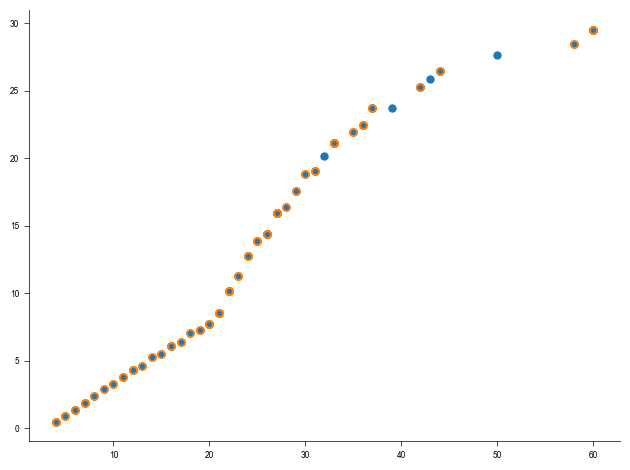

In [5]:
from pymoo.indicators.hv import HV
ref_point = np.array([126, 0])
hv = HV(ref_point=ref_point)

pulse_combo_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Combinatorial_search/pulse_tpulse_pareto_dsred1_final.pkl"
path_GA = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_5/final_objectives_df.pkl"
pulse_pareto = pd.read_pickle(pulse_combo_path)
print(pulse_pareto)
hv_combo = hv(pulse_pareto)
print(hv_combo)
print(len(pulse_pareto))
pulse_GA = pd.read_pickle(path_GA)
display(pulse_GA.drop_duplicates())

plt.plot(pulse_pareto[:,0], abs(pulse_pareto[:, 1]), linestyle="none", marker="o")
plt.plot(pulse_GA["t_pulse"], abs(pulse_GA["prominence_rel"]), linestyle="none", marker="o", fillstyle="none")

In [60]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Pulse_single_cell/Optimized_hyperparams/t_pulse/Optimized_hyperparams_fixed_pop_max_hv/2024-10-09_Pulse_single_DsRED_t_pulse_opt_hps_ngen80_seed_6/hypervolumes.pkl"
hvs = pd.read_pickle(path)
print(hvs[-1])

2779.909264535736


In [ ]:
2880.993101067119